# **Hyperparameter tuning**

In [1]:
import os
import sys
import warnings; warnings.filterwarnings('ignore')

import pandas as pd

utils_path = os.path.join(os.getcwd(), '..', '..', '..')
if utils_path not in sys.path:
    sys.path.insert(0, utils_path)

from notebooks.src.utils import plots, constants

## **Constants**

In [7]:
TUNING_FOLDER = constants.TUNING_FOLDER

TUNING_RAW_FOLDER = os.path.join(TUNING_FOLDER, 'raw')
TUNING_CLEANED_FOLDER = os.path.join(TUNING_FOLDER, 'cleaned')

LVL1_RESULTS = os.path.join(TUNING_RAW_FOLDER, 'lvl1_without_sentencepiece.csv')
LVL2_RESULTS = os.path.join(TUNING_RAW_FOLDER, 'lvl2.csv')
LVL3_TRANSFORMER_GN_ES_RESULTS = os.path.join(TUNING_CLEANED_FOLDER, 
                                              'lvl3_transformer_gn_es.csv')
LVL3_TRANSFORMER_ES_GN_RESULTS = os.path.join(TUNING_CLEANED_FOLDER, 
                                              'lvl3_transformer_es_gn.csv')
LVL3_S2S_GN_ES_RESULTS = os.path.join(TUNING_CLEANED_FOLDER, 
                                      'lvl3_s2s_gn_es.csv')
LVL3_S2S_ES_GN_RESULTS = os.path.join(TUNING_CLEANED_FOLDER, 
                                      'lvl3_s2s_es_gn.csv')

BEST_MODELS_CSV = os.path.join(TUNING_CLEANED_FOLDER, 
                               'best_models.csv')

FIGSIZE_LEVEL1 = (16, 5)

## **Level 1**

Here we tested the default hyperparameters to have a baseline for our tuned models.

In [75]:
lvl1_df = pd.read_csv(LVL1_RESULTS)
lvl1_df.tail()

date                  model_name           source  \
191  2023-07-26 14:06:16.307205  es_gn_lvl1_transformer.npz  valid_es.txt.es   
192  2023-07-26 14:07:36.626009  es_gn_lvl1_transformer.npz  valid_es.txt.es   
193  2023-07-26 14:07:36.626009  es_gn_lvl1_transformer.npz  valid_es.txt.es   
194  2023-07-26 14:08:53.427986  es_gn_lvl1_transformer.npz  valid_es.txt.es   
195  2023-07-26 14:08:53.427986  es_gn_lvl1_transformer.npz  valid_es.txt.es   

              target             score_type      score  epoch  \
191  valid_gn.txt.gn  sacrebleu_corpus_bleu   2.738466      7   
192  valid_gn.txt.gn  sacrebleu_corpus_chrf  17.213538      8   
193  valid_gn.txt.gn  sacrebleu_corpus_bleu   2.614965      8   
194  valid_gn.txt.gn  sacrebleu_corpus_chrf  18.309891      9   
195  valid_gn.txt.gn  sacrebleu_corpus_bleu   2.817177      9   

                                            parameters  
191  {'devices': ['0', '1'], 'early-stopping': ['7'...  
192  {'devices': ['0', '1'], 'early-stopping': ['7'...  
193  {'devices': ['0', '1'], 'early-stopping': ['7'...  
194  {'devices': ['0', '1'], 'early-stopping': ['7'...  
195  {'devices': ['0', '1'], 'early-stopping': ['7'...

**Visual analysis**

In [76]:
gn_es_results = lvl1_df[lvl1_df['source'].str.contains('gn', regex=False)]
es_gn_results = lvl1_df[lvl1_df['source'].str.contains('es', regex=False)]

### **GN -> ES**

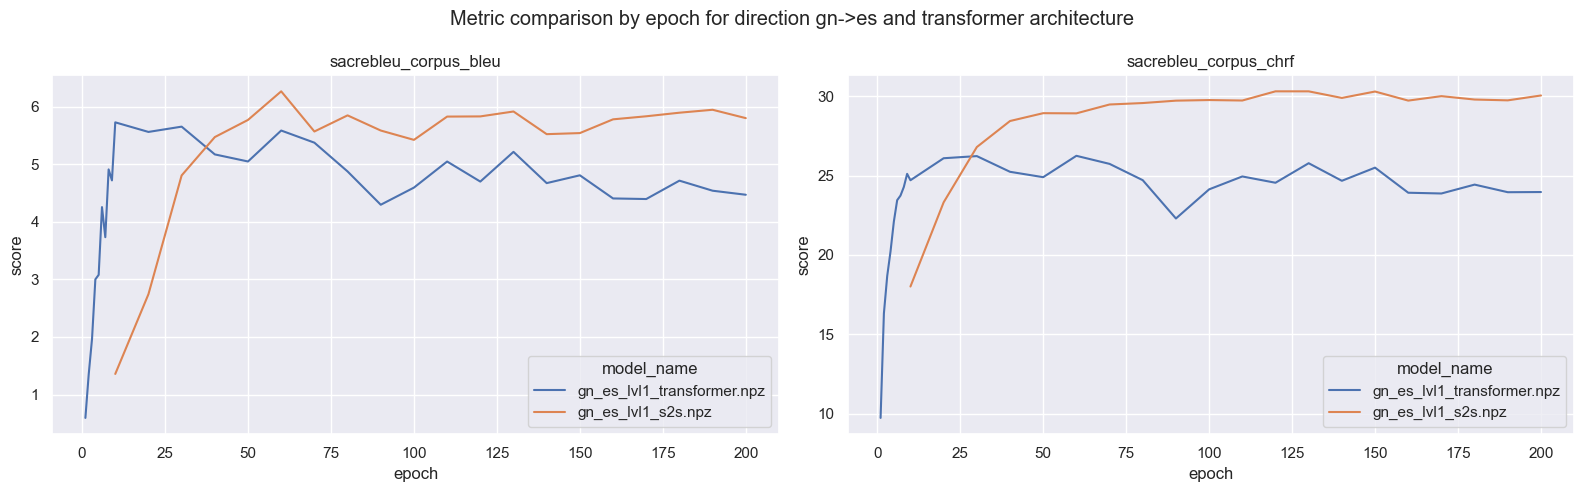

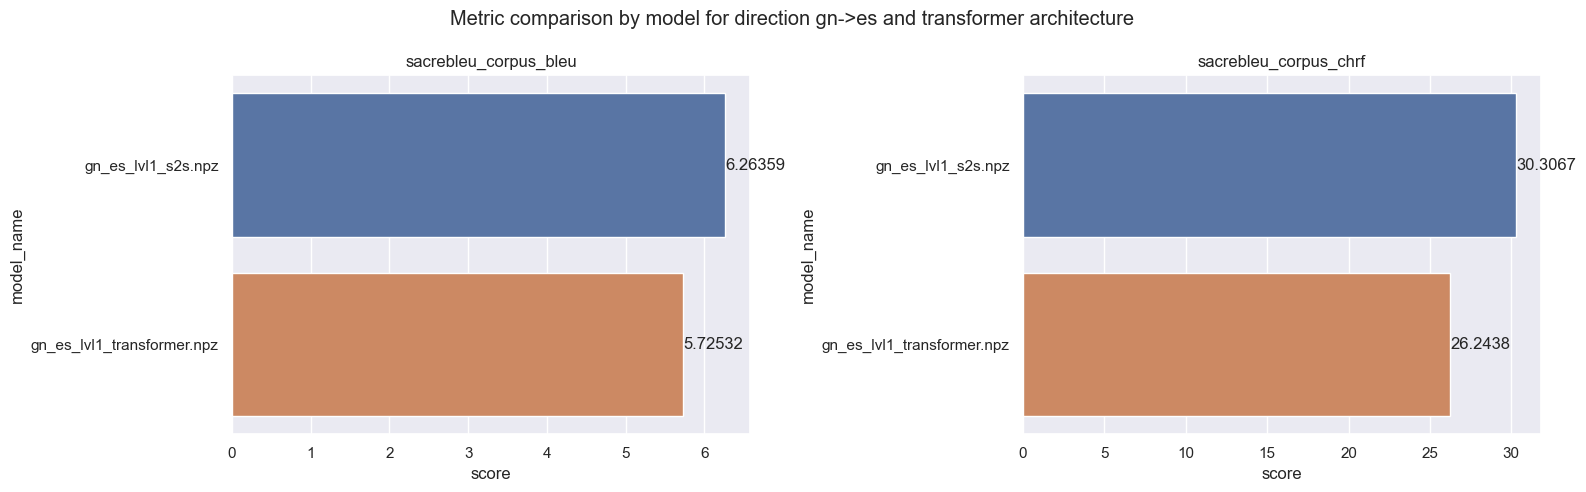

In [77]:
plots.plot_metric_by_epoch_foreach_model(gn_es_results, 
                                         metrics=['sacrebleu_corpus_bleu', 
                                                  'sacrebleu_corpus_chrf'], 
                                         figsize=FIGSIZE_LEVEL1);

plots.plot_max_score_by_model(gn_es_results, 
                              metrics=['sacrebleu_corpus_bleu', 
                                       'sacrebleu_corpus_chrf'], 
                              figsize=FIGSIZE_LEVEL1);

### **ES -> GN**

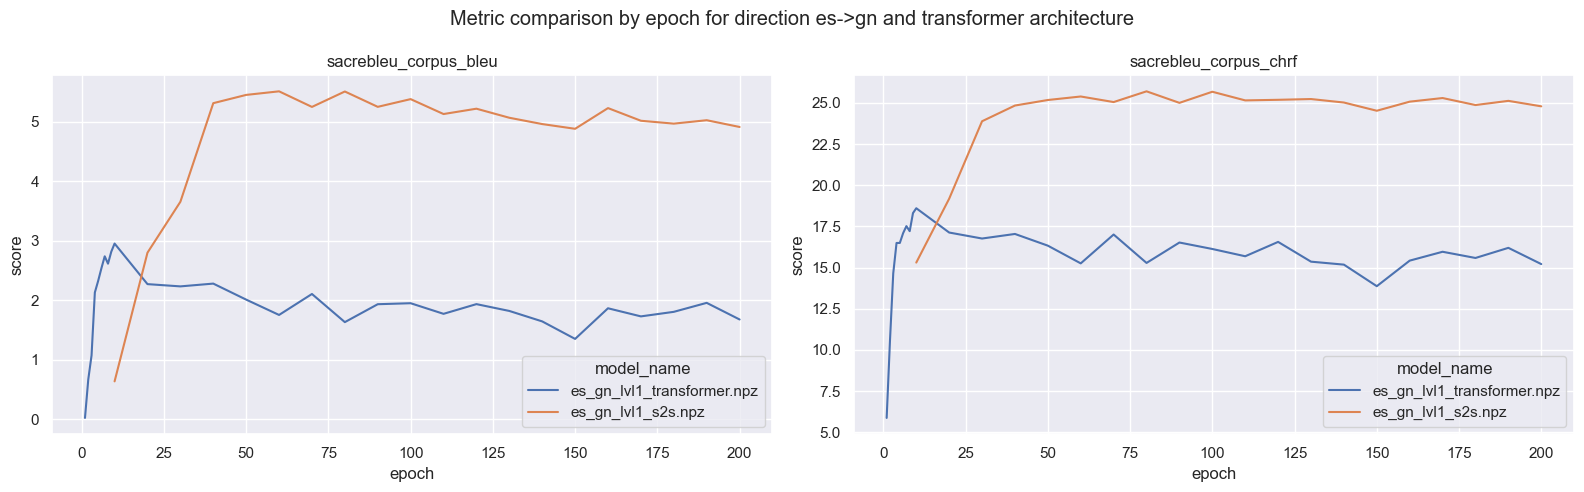

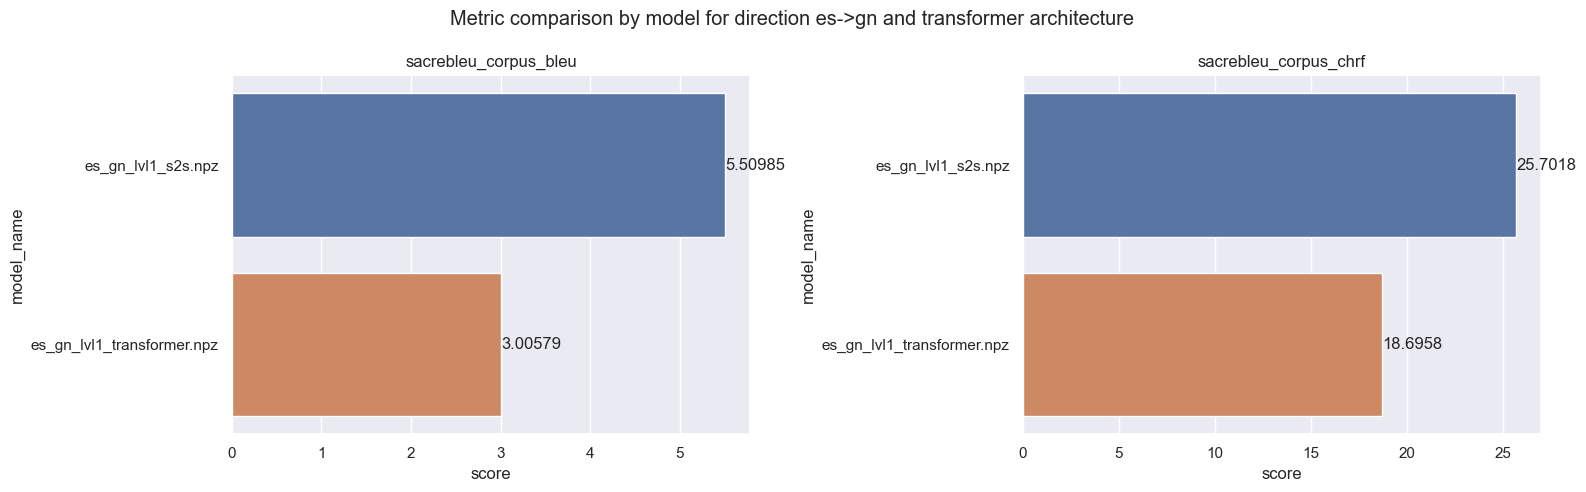

In [73]:
plots.plot_metric_by_epoch_foreach_model(es_gn_results, 
                                         metrics=['sacrebleu_corpus_bleu', 
                                                  'sacrebleu_corpus_chrf'], 
                                         figsize=FIGSIZE_LEVEL1);
plots.plot_max_score_by_model(es_gn_results, 
                              metrics=['sacrebleu_corpus_bleu', 
                                       'sacrebleu_corpus_chrf'], 
                              figsize=FIGSIZE_LEVEL1);

In [97]:
#lvl1_df.groupby(['source', 'score_type', 'model_name'], group_keys=False).apply(lambda x: x.sort_values('score', ascending=False).head(1)).sort_values(['model_name', 'score_type'])

def get_best_experiment_scores_by_metric(df: pd.DataFrame, score_type='sacrebleu_corpus_chrf', groupby=['source', 'score_type', 'model_name']):
    return (df[df['score_type']==score_type].groupby(groupby, group_keys=False)
                                            .apply(lambda x: x.sort_values('score', ascending=False)
                                            .head(1)))

def get_every_experiment_score(full_df: pd.DataFrame, experiments_df: pd.DataFrame):
    return (full_df.merge(experiments_df,
                          on=['source', 'model_name', 'epoch'], 
                          how='inner')
                   .sort_values(['score_type_x', 'score_x', 'model_name'], ascending=False))

def pivot_best_experiment_scores(df: pd.DataFrame):
    df = df[['model_name', 'source', 'target_x', 'score_type_x', 'score_x', 'epoch']]
    return df.pivot(index=['model_name', 'source', 'target_x', 'epoch'], 
                    columns='score_type_x', 
                    values='score_x').reset_index()

def get_best_experiment_scores(df: pd.DataFrame, groupby=['source', 'score_type', 'model_name']):
    best_experiment_scores_by_chrf = get_best_experiment_scores_by_metric(df, 
                                                                          score_type='sacrebleu_corpus_chrf', 
                                                                          groupby=groupby)
    best_experiment_scores = get_every_experiment_score(df,
                                                        best_experiment_scores_by_chrf)
    pivoted_best_experiment_scores = pivot_best_experiment_scores(best_experiment_scores)
    return pivoted_best_experiment_scores


get_best_experiment_scores(lvl1_df)

score_type_x                  model_name           source         target_x  \
0                     es_gn_lvl1_s2s.npz  valid_es.txt.es  valid_gn.txt.gn   
1             es_gn_lvl1_transformer.npz  valid_es.txt.es  valid_gn.txt.gn   
2                     gn_es_lvl1_s2s.npz  valid_gn.txt.gn  valid_es.txt.es   
3             gn_es_lvl1_transformer.npz  valid_gn.txt.gn  valid_es.txt.es   

score_type_x  epoch  sacrebleu_corpus_bleu  sacrebleu_corpus_chrf  
0                80               5.507029              25.701832  
1                10               3.005788              18.695834  
2               120               5.828194              30.306721  
3                60               5.583044              26.243839

## **Level 2**

In this section we tested multiple hyperparameters using coordinate-wise optimization
in order to get more interpretable preliminar results.

In [172]:
lvl2_df = pd.read_csv(LVL2_RESULTS)
lvl2_df.tail()

date  \
1083  2023-08-04 18:50:13.247111   
1084  2023-08-04 19:39:19.335075   
1085  2023-08-04 19:39:19.335075   
1086  2023-08-04 20:28:25.415945   
1087  2023-08-04 20:28:25.415945   

                                             model_name           source  \
1083  lvl2_grid_gn_es_s2s_from15_to16_max-length_200...  valid_gn.txt.gn   
1084  lvl2_grid_gn_es_s2s_from15_to16_max-length_200...  valid_gn.txt.gn   
1085  lvl2_grid_gn_es_s2s_from15_to16_max-length_200...  valid_gn.txt.gn   
1086  lvl2_grid_gn_es_s2s_from15_to16_max-length_200...  valid_gn.txt.gn   
1087  lvl2_grid_gn_es_s2s_from15_to16_max-length_200...  valid_gn.txt.gn   

               target             score_type      score  epoch  \
1083  valid_es.txt.es  sacrebleu_corpus_bleu  15.481119    380   
1084  valid_es.txt.es  sacrebleu_corpus_chrf  36.378641    390   
1085  valid_es.txt.es  sacrebleu_corpus_bleu  15.409644    390   
1086  valid_es.txt.es  sacrebleu_corpus_chrf  36.290605    400   
1087  valid_es.txt.es  sacrebleu_corpus_bleu  15.194003    400   

                                             parameters  
1083  {'type': ['s2s'], 'devices': ['0'], 'train-set...  
1084  {'type': ['s2s'], 'devices': ['0'], 'train-set...  
1085  {'type': ['s2s'], 'devices': ['0'], 'train-set...  
1086  {'type': ['s2s'], 'devices': ['0'], 'train-set...  
1087  {'type': ['s2s'], 'devices': ['0'], 'train-set...

In [173]:
gn_es_lvl2_results = lvl2_df[lvl2_df['source'].str.contains('gn', regex=False)]
es_gn_lvl2_results = lvl2_df[lvl2_df['source'].str.contains('es', regex=False)]

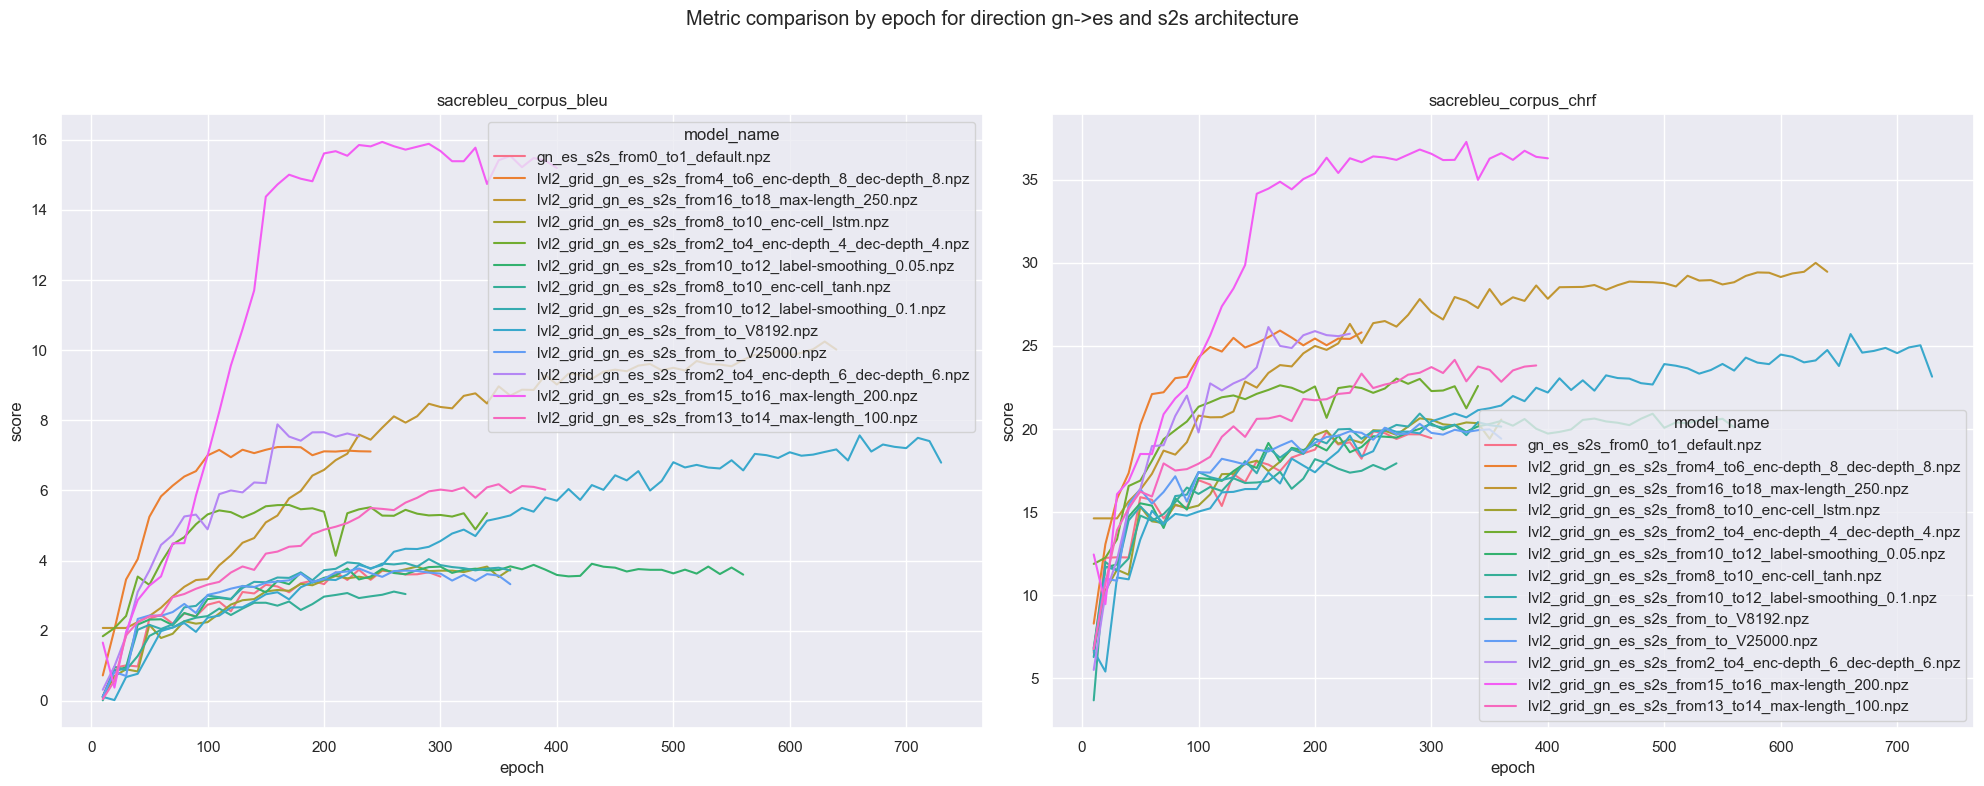

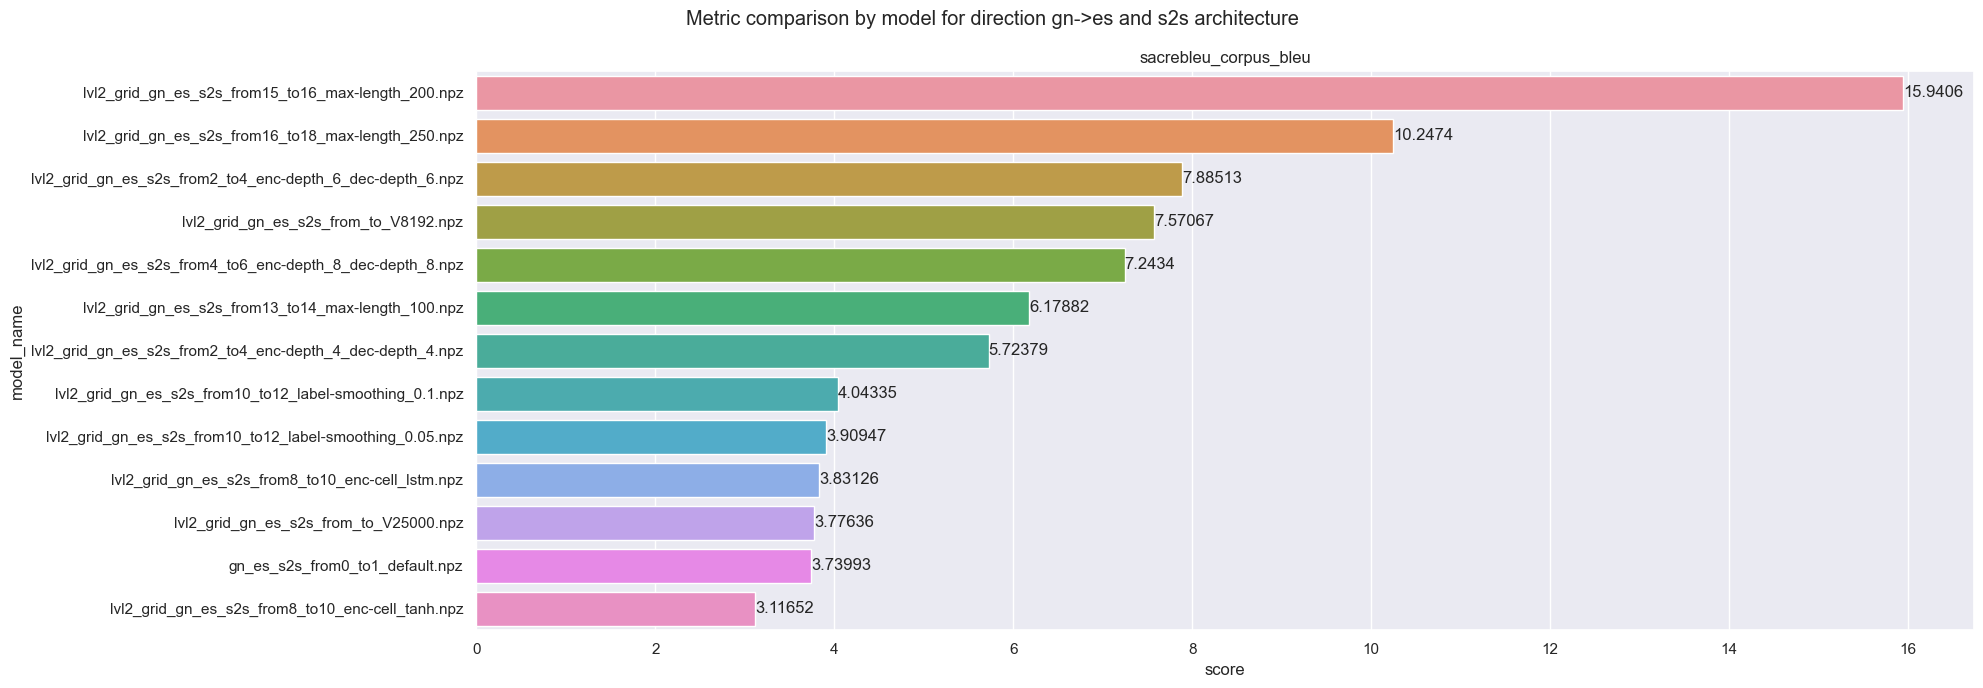

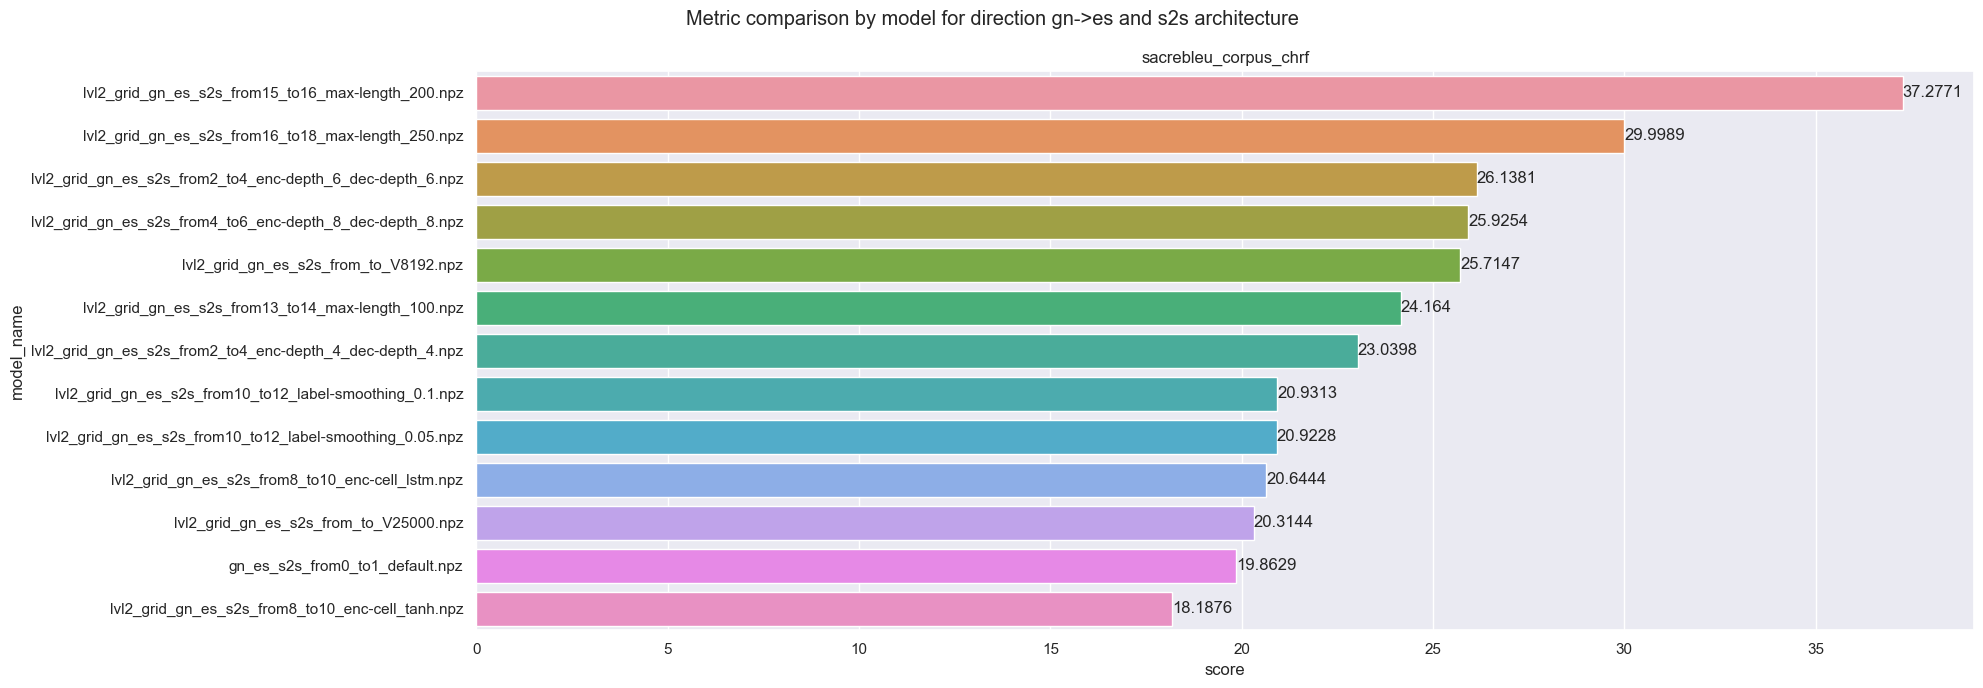

In [174]:
plots.plot_metric_by_epoch_foreach_model(gn_es_lvl2_results, 
                                         metrics=['sacrebleu_corpus_bleu', 
                                                  'sacrebleu_corpus_chrf'], 
                                         figsize=(20,8));
plots.plot_max_score_by_model(gn_es_lvl2_results, 
                              metrics=['sacrebleu_corpus_bleu'], 
                              figsize=(20,7))
plots.plot_max_score_by_model(gn_es_lvl2_results, 
                              metrics=['sacrebleu_corpus_chrf'], 
                              figsize=(20,7))

In [200]:
get_best_experiment_scores(lvl2_df)

score_type_x                                                                              sacrebleu_corpus_bleu  \
model_name                                         source          target_x        epoch                          
gn_es_s2s_from0_to1_default.npz                    valid_gn.txt.gn valid_es.txt.es 250                 3.713158   
lvl2_grid_gn_es_s2s_from10_to12_label-smoothing... valid_gn.txt.gn valid_es.txt.es 490                 3.738219   
lvl2_grid_gn_es_s2s_from10_to12_label-smoothing... valid_gn.txt.gn valid_es.txt.es 290                 4.043353   
lvl2_grid_gn_es_s2s_from13_to14_max-length_100.npz valid_gn.txt.gn valid_es.txt.es 320                 6.086404   
lvl2_grid_gn_es_s2s_from15_to16_max-length_200.npz valid_gn.txt.gn valid_es.txt.es 330                15.776506   
lvl2_grid_gn_es_s2s_from16_to18_max-length_250.npz valid_gn.txt.gn valid_es.txt.es 630                10.247390   
lvl2_grid_gn_es_s2s_from2_to4_enc-depth_4_dec-d... valid_gn.txt.gn valid_es.txt.es 270                 5.448664   
lvl2_grid_gn_es_s2s_from2_to4_enc-depth_6_dec-d... valid_gn.txt.gn valid_es.txt.es 160                 7.885129   
lvl2_grid_gn_es_s2s_from4_to6_enc-depth_8_dec-d... valid_gn.txt.gn valid_es.txt.es 170                 7.243399   
lvl2_grid_gn_es_s2s_from8_to10_enc-cell_lstm.npz   valid_gn.txt.gn valid_es.txt.es 290                 3.700672   
lvl2_grid_gn_es_s2s_from8_to10_enc-cell_tanh.npz   valid_gn.txt.gn valid_es.txt.es 200                 2.973063   
lvl2_grid_gn_es_s2s_from_to_V25000.npz             valid_gn.txt.gn valid_es.txt.es 290                 3.659151   
lvl2_grid_gn_es_s2s_from_to_V8192.npz              valid_gn.txt.gn valid_es.txt.es 660                 7.570673   

score_type_x                                                                              sacrebleu_corpus_chrf  
model_name                                         source          target_x        epoch                         
gn_es_s2s_from0_to1_default.npz                    valid_gn.txt.gn valid_es.txt.es 250                19.862937  
lvl2_grid_gn_es_s2s_from10_to12_label-smoothing... valid_gn.txt.gn valid_es.txt.es 490                20.922784  
lvl2_grid_gn_es_s2s_from10_to12_label-smoothing... valid_gn.txt.gn valid_es.txt.es 290                20.931333  
lvl2_grid_gn_es_s2s_from13_to14_max-length_100.npz valid_gn.txt.gn valid_es.txt.es 320                24.163997  
lvl2_grid_gn_es_s2s_from15_to16_max-length_200.npz valid_gn.txt.gn valid_es.txt.es 330                37.277129  
lvl2_grid_gn_es_s2s_from16_to18_max-length_250.npz valid_gn.txt.gn valid_es.txt.es 630                29.998861  
lvl2_grid_gn_es_s2s_from2_to4_enc-depth_4_dec-d... valid_gn.txt.gn valid_es.txt.es 270                23.039828  
lvl2_grid_gn_es_s2s_from2_to4_enc-depth_6_dec-d... valid_gn.txt.gn valid_es.txt.es 160                26.138085  
lvl2_grid_gn_es_s2s_from4_to6_enc-depth_8_dec-d... valid_gn.txt.gn valid_es.txt.es 170                25.925366  
lvl2_grid_gn_es_s2s_from8_to10_enc-cell_lstm.npz   valid_gn.txt.gn valid_es.txt.es 290                20.644400  
lvl2_grid_gn_es_s2s_from8_to10_enc-cell_tanh.npz   valid_gn.txt.gn valid_es.txt.es 200                18.187602  
lvl2_grid_gn_es_s2s_from_to_V25000.npz             valid_gn.txt.gn valid_es.txt.es 290                20.314355  
lvl2_grid_gn_es_s2s_from_to_V8192.npz              valid_gn.txt.gn valid_es.txt.es 660                25.714738

### **Level 2 metrics by hyperparameter**

```
- (enc-depth, dec-depth):   [(1, 1) {default}, (2, 2), (4, 4), (6, 6), (8, 8)]
- enc-cell:                 ["lstm", "tanh", "gru" {default}]
- sentencepiece-dim-vocabs: [2^13, 2^14 {our default}, 2^15]
- label-smoothing:          [0 {default}, 0.05, 0.1]
- max-length:               [100, 150, 200, 250]
```

In [176]:
def extract_features(lvl1_df: pd.DataFrame, lvl2_df: pd.DataFrame, feature: str, column='parameters'):
    filtered_df = lvl2_df[lvl2_df[column].str.contains(feature)]
    default_df = lvl2_df[lvl2_df['model_name'].str.contains('default')]
    filtered_df = pd.concat([default_df, filtered_df])
    #lvl1_results = lvl1_df[lvl1_df['model_name'].str.contains('lvl1')]
    #filtered_df = pd.concat([filtered_df, lvl1_results])

    return filtered_df

#### **GN -> ES**

##### **Seq2Seq**

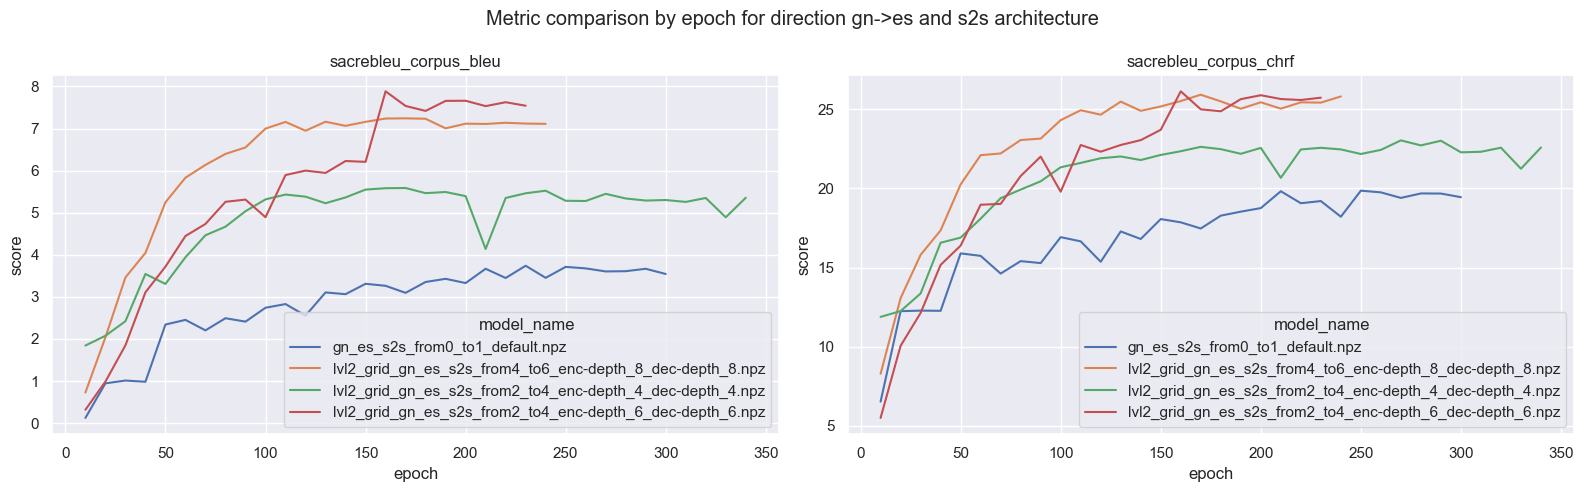

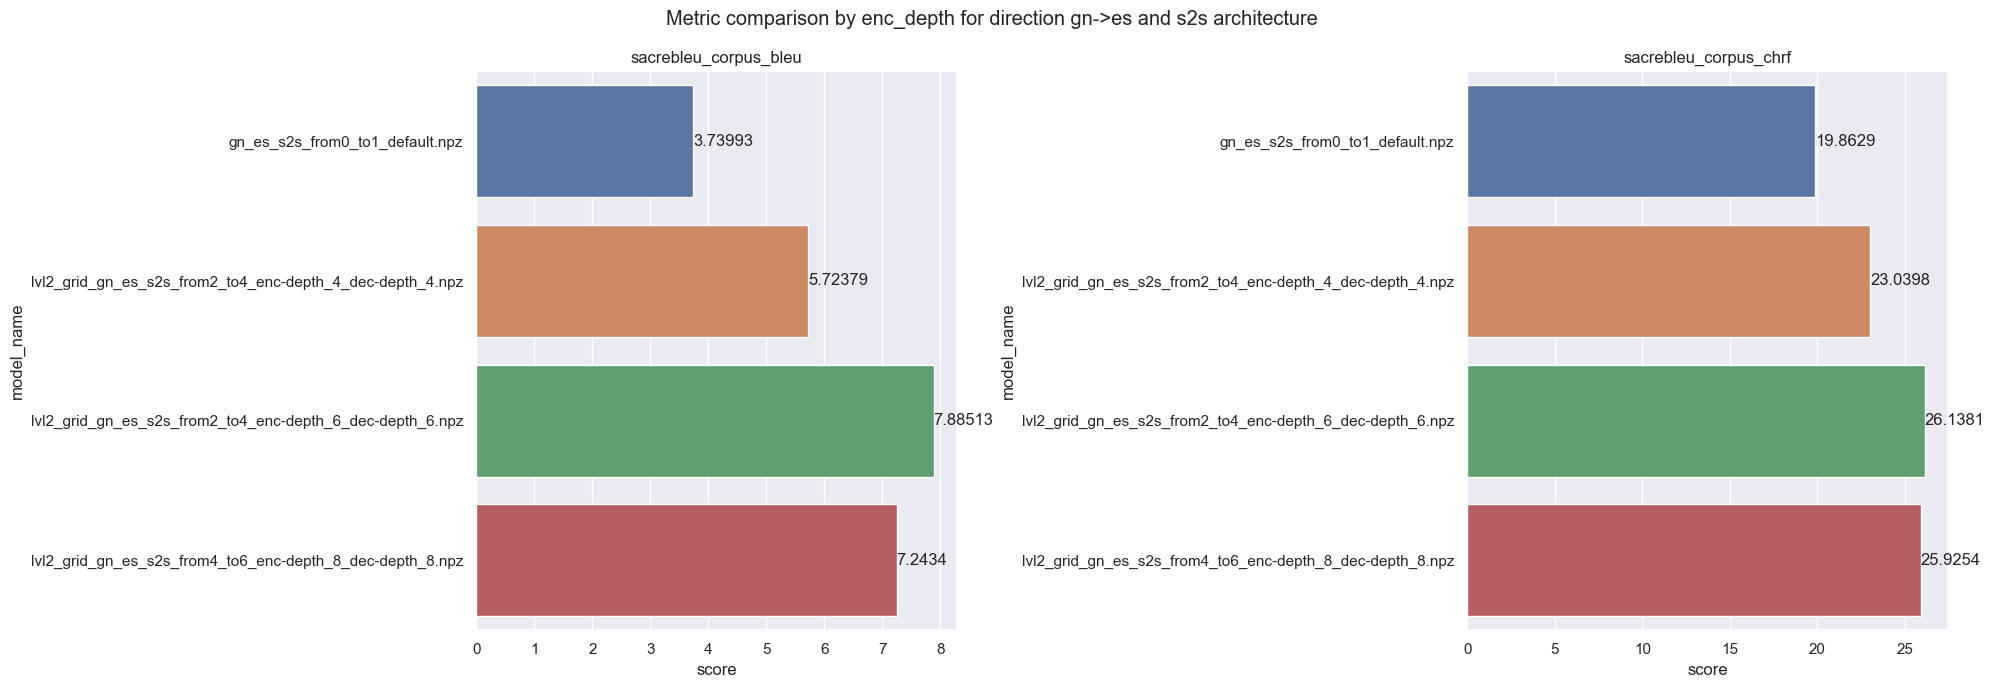

In [177]:
enc_dec_depth_df = extract_features(gn_es_results, 
                                    gn_es_lvl2_results, 
                                    'enc-depth')
plots.plot_metric_by_epoch_foreach_model(enc_dec_depth_df, 
                                         metrics=['sacrebleu_corpus_bleu', 
                                                  'sacrebleu_corpus_chrf'], 
                                         figsize=(16,5));

enc_dec_depth_df_sorted_by_depth = enc_dec_depth_df.copy()
enc_dec_depth_df_sorted_by_depth['enc_depth'] = [int(x[-5]) if 'enc-depth' in x else 1 \
                                                 for x in enc_dec_depth_df_sorted_by_depth['model_name']]
plots.plot_max_score_by_model(enc_dec_depth_df_sorted_by_depth, 
                              metrics=['sacrebleu_corpus_bleu', 
                                       'sacrebleu_corpus_chrf'], 
                              figsize=(20,7), 
                              by='enc_depth', 
                              sort_by='enc_depth', 
                              ascending=True);

**Encoder Cell**

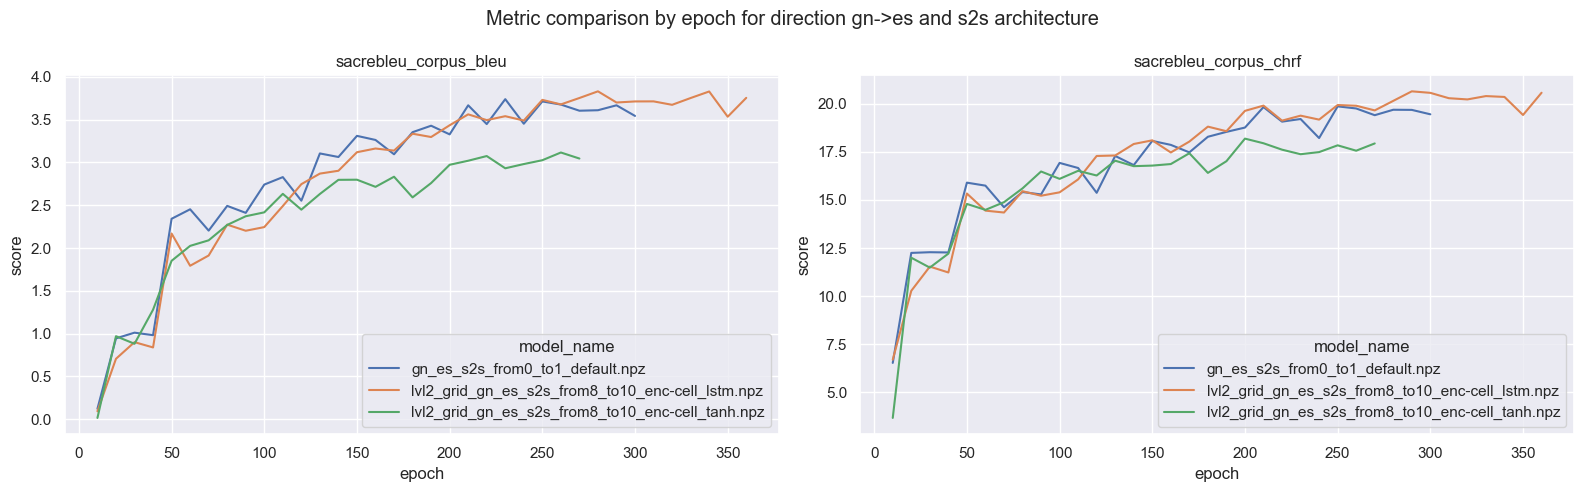

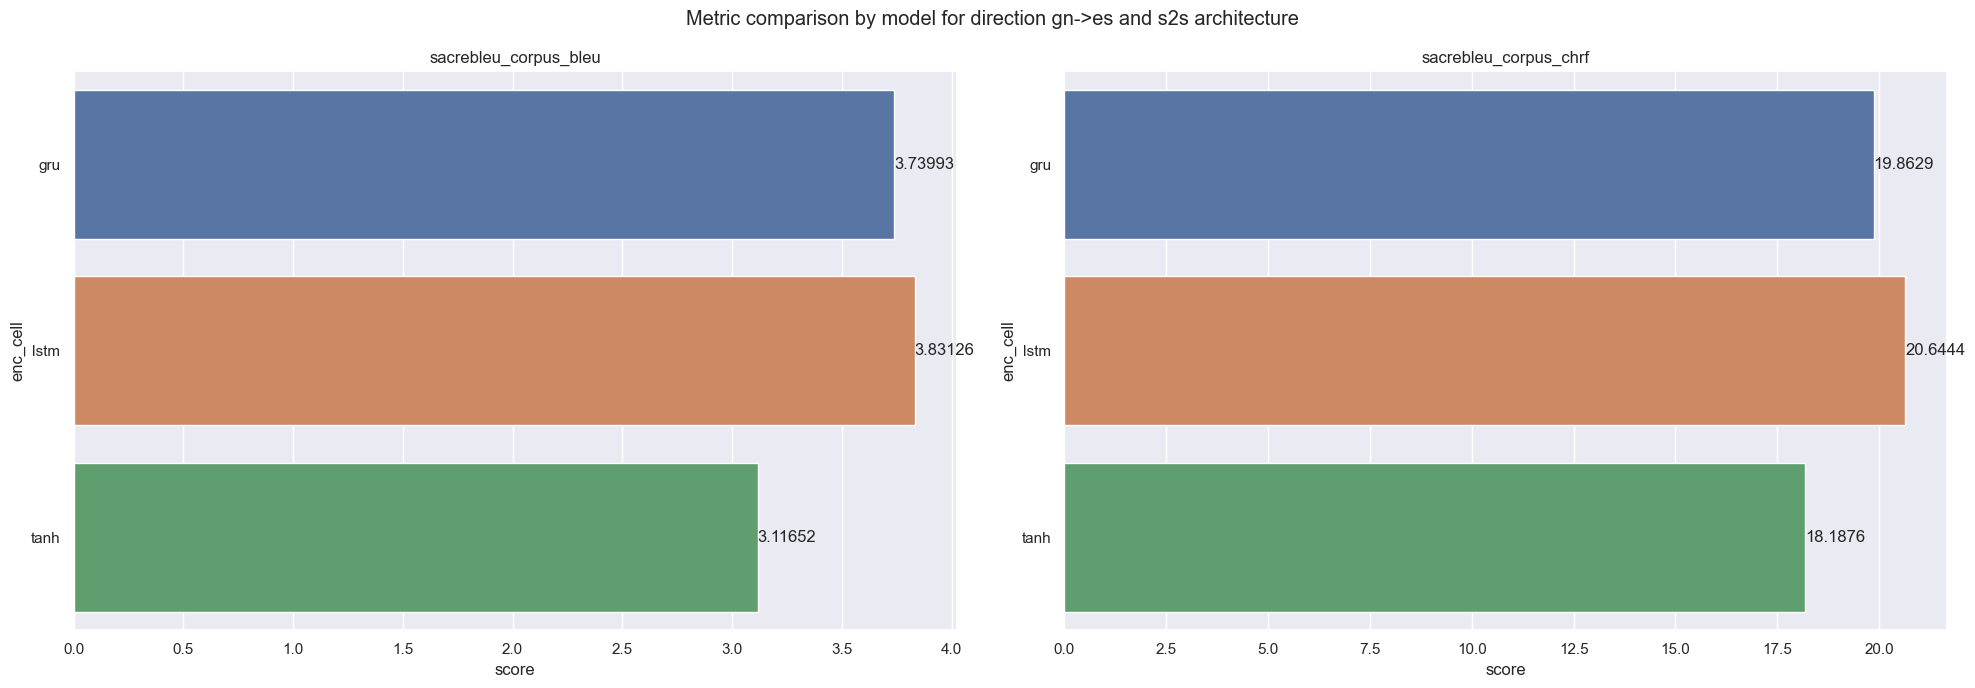

In [178]:
enc_cell_df = extract_features(gn_es_results, 
                               gn_es_lvl2_results, 
                               'enc-cell')
plots.plot_metric_by_epoch_foreach_model(enc_cell_df, 
                                         metrics=['sacrebleu_corpus_bleu', 
                                                  'sacrebleu_corpus_chrf'], 
                                         figsize=(16,5))

enc_cell_df['enc_cell'] = [x[-8:-4] if 'enc-cell' in x else 'gru' \
                           for x in enc_cell_df['model_name']]
plots.plot_max_score_by_model(enc_cell_df, 
                              metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], 
                              figsize=(20,7), 
                              y_col='enc_cell', 
                              sort_by='enc_cell', 
                              ascending=True);

**Sentence Piece Vocab Size**

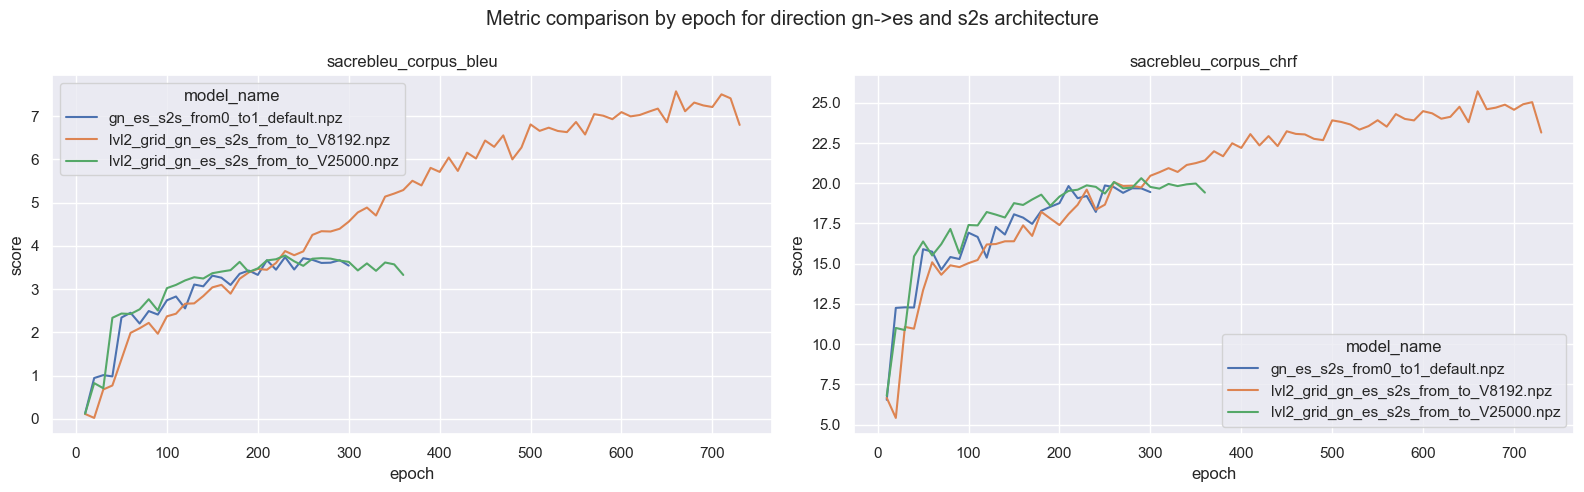

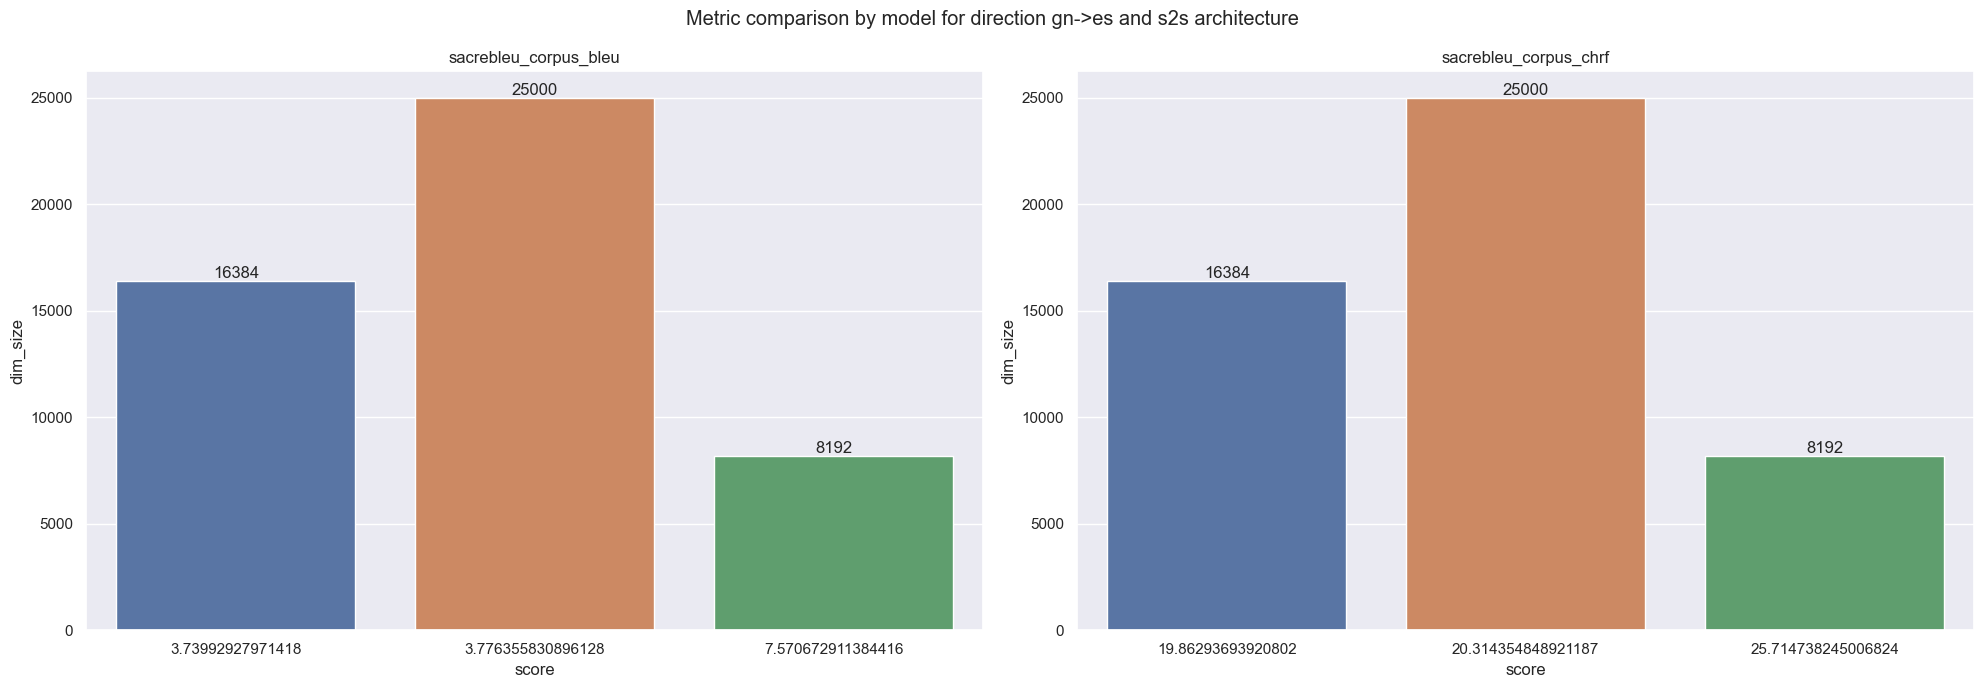

In [179]:
dim_size_df = extract_features(gn_es_results, 
                               gn_es_lvl2_results, 
                               '_V', 
                               column='model_name')
plots.plot_metric_by_epoch_foreach_model(dim_size_df, 
                                         metrics=['sacrebleu_corpus_bleu', 
                                                  'sacrebleu_corpus_chrf'], 
                                         figsize=(16,5));

dim_size_df['dim_size'] = [int(x[-9:-4].replace('V','')) if 'V' in x \
                           else 2**14 \
                           for x in dim_size_df['model_name']]
plots.plot_max_score_by_model(dim_size_df,
                              metrics=['sacrebleu_corpus_bleu', 
                                       'sacrebleu_corpus_chrf'], 
                              figsize=(20,7), 
                              y_col='dim_size', 
                              sort_by='dim_size', 
                              ascending=True);

**Label smoothing**

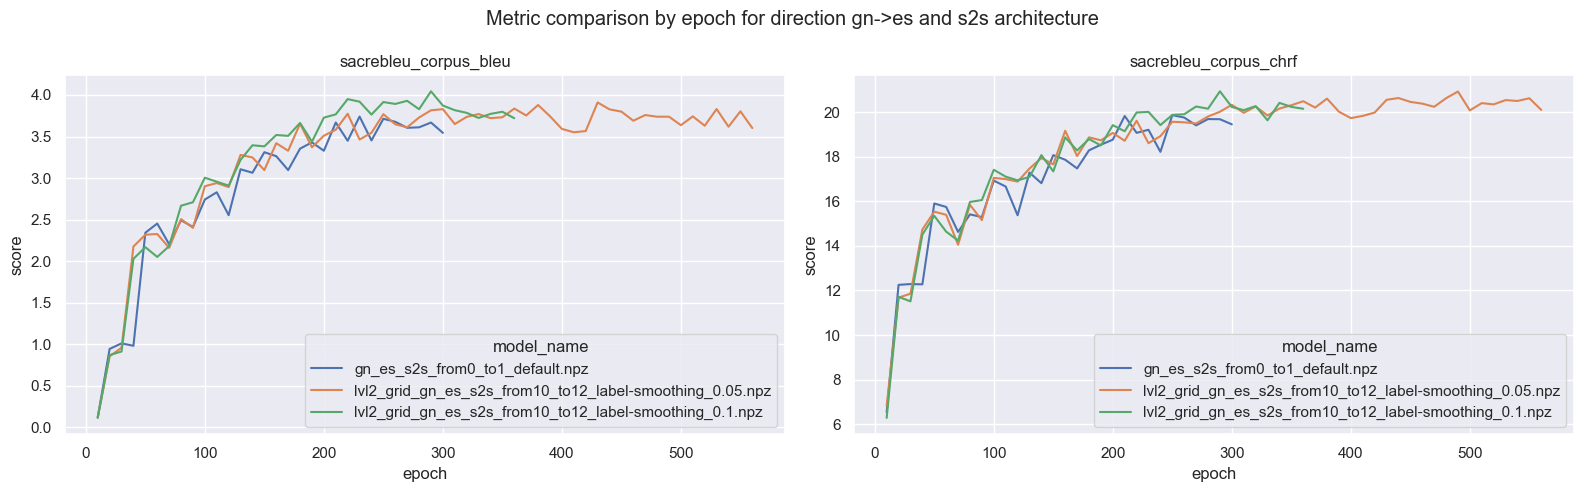

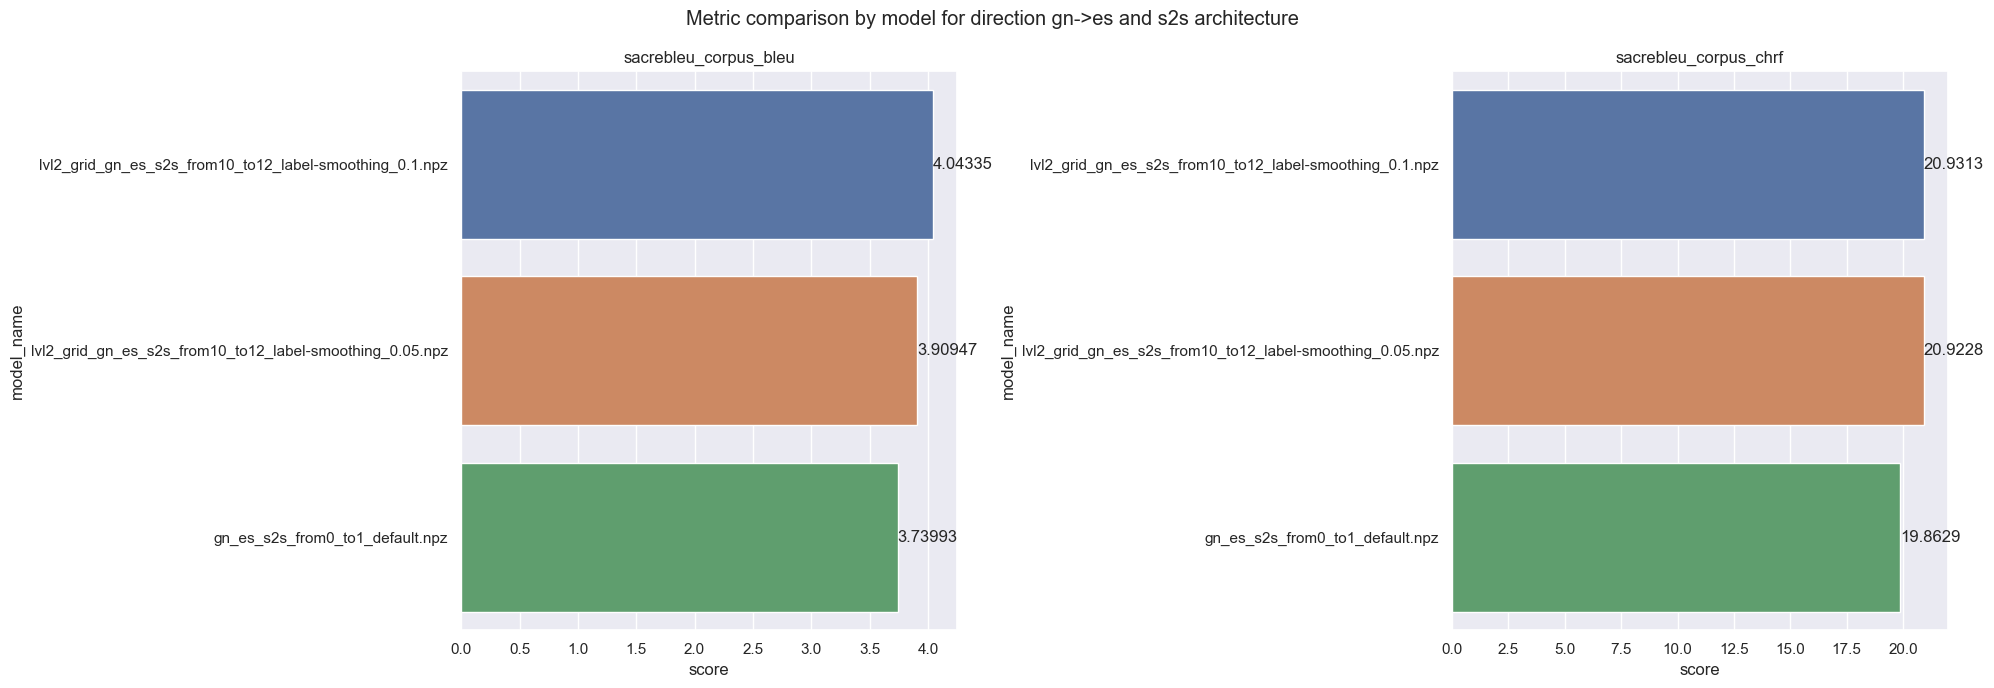

In [180]:
enc_dec_depth_df = extract_features(gn_es_results,
                                    gn_es_lvl2_results,
                                    'label-smoothing')
plots.plot_metric_by_epoch_foreach_model(enc_dec_depth_df,
                                         metrics=['sacrebleu_corpus_bleu',
                                                  'sacrebleu_corpus_chrf'],
                                         figsize=(16,5));
plots.plot_max_score_by_model(enc_dec_depth_df,
                              metrics=['sacrebleu_corpus_bleu',
                                       'sacrebleu_corpus_chrf'],
                              figsize=(20,7));

**Sentence max length**

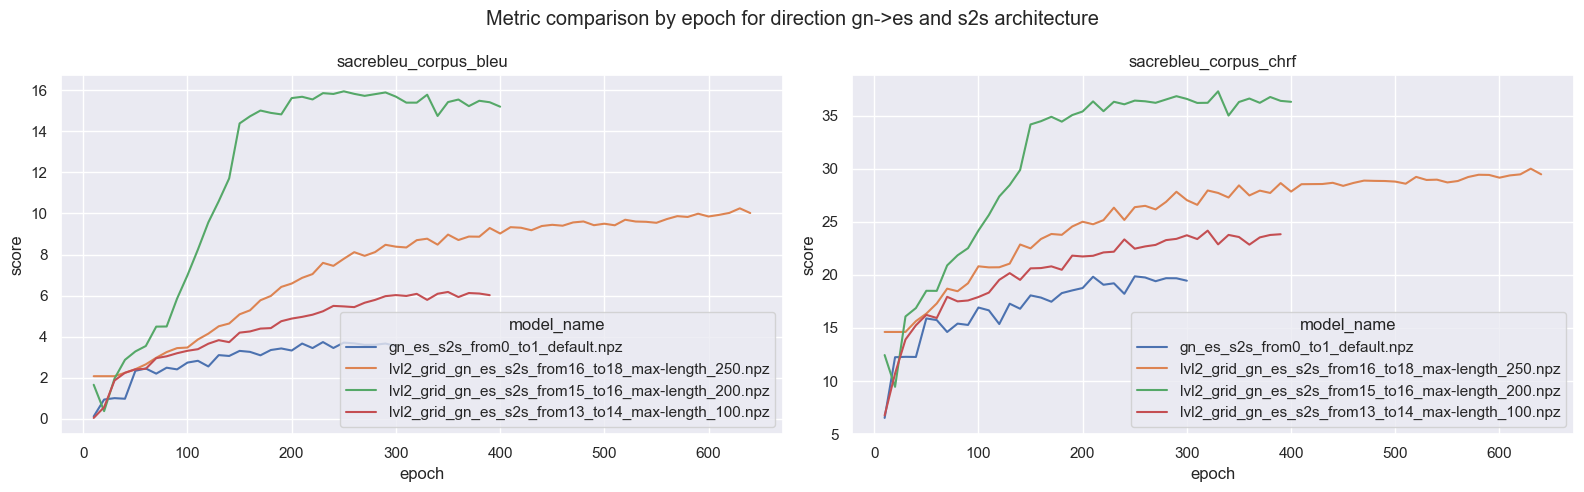

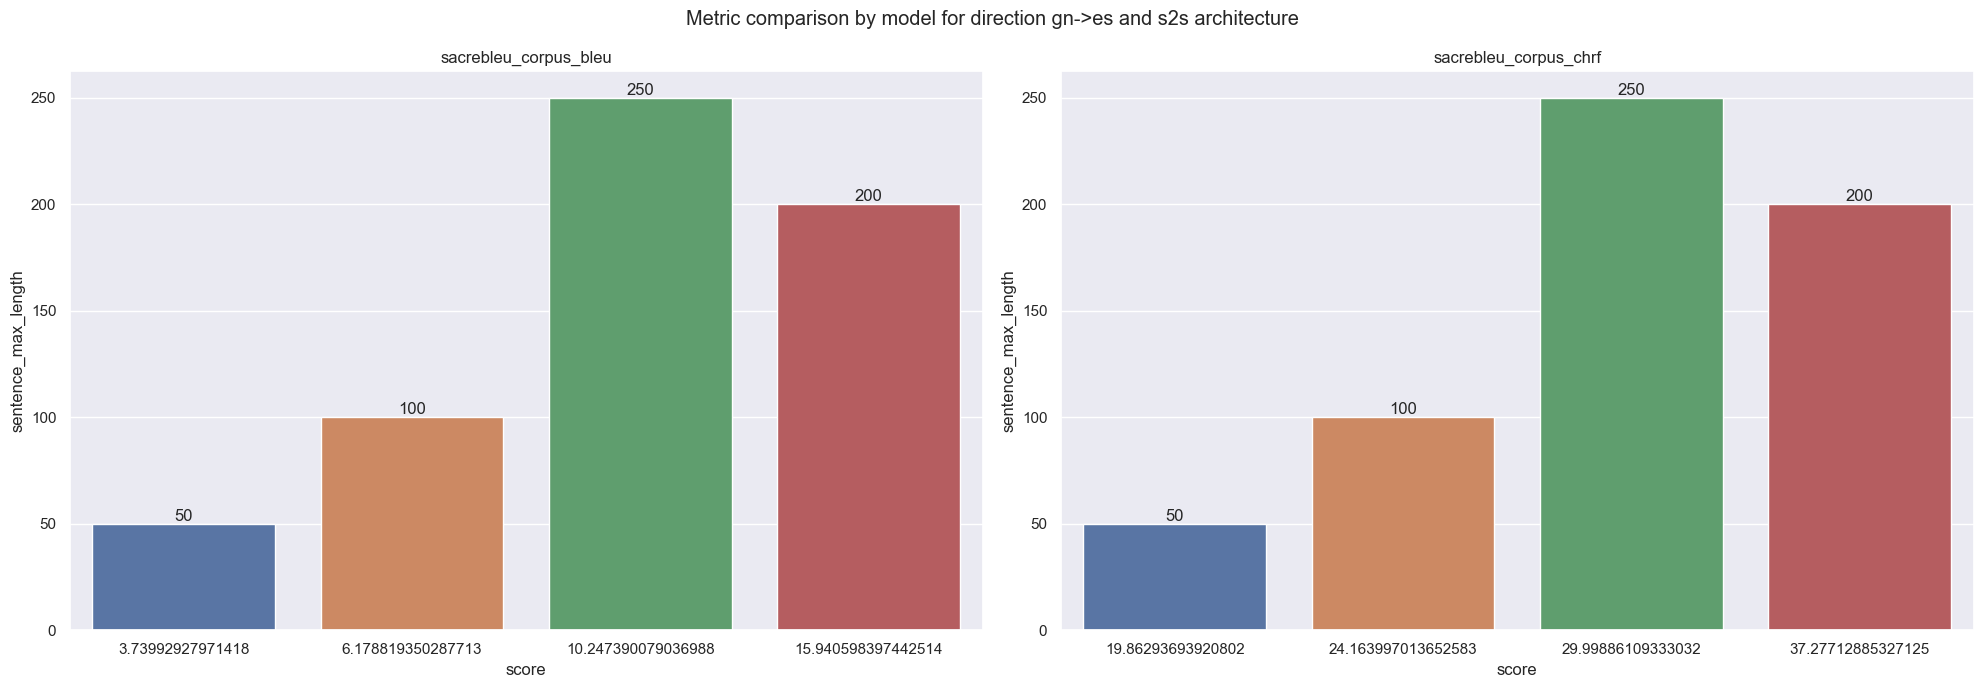

In [181]:
sentence_max_length_df = extract_features(gn_es_results, gn_es_lvl2_results,
                                          'max-length',
                                          column='model_name')
plots.plot_metric_by_epoch_foreach_model(sentence_max_length_df,
                                         metrics=['sacrebleu_corpus_bleu', 
                                                  'sacrebleu_corpus_chrf'],
                                         figsize=(16,5))

sentence_max_length_df['sentence_max_length'] = [int(x[-7:-4]) if 'max-length' in x \
                                                 else 50 \
                                                 for x in sentence_max_length_df['model_name']]
plots.plot_max_score_by_model(sentence_max_length_df,
                              metrics=['sacrebleu_corpus_bleu', 
                                       'sacrebleu_corpus_chrf'],
                              figsize=(20,7),
                              y_col='sentence_max_length',
                              sort_by='sentence_max_length',
                              ascending=True);

## **Level 3**

**Hyperparameters:**

```
- (enc-depth, dec-depth):   [(1, 1) {default}, (2, 2), (4, 4), (6, 6), (8, 8)]
- sentencepiece-dim-vocabs: [2^13, 2^14 {our default}, 2^15]
- label-smoothing:          [0 {default}, 0.05, 0.1]
- max-length:               [100, 150, 200, 250]
- crop-max-length:          [true {our default}]

```

##### **S2S: GN -> ES**

In [182]:
gn_es_lvl3_results_df = pd.read_csv(LVL3_S2S_GN_ES_RESULTS)
gn_es_lvl3_results_df.tail()

date  \
1093  2023-09-03 03:47:19.557109   
1094  2023-09-03 04:35:15.158963   
1095  2023-09-03 04:35:15.158963   
1096  2023-09-03 05:22:16.909329   
1097  2023-09-03 05:22:16.909329   

                                             model_name           source  \
1093  lvl3_grid_gn_es_s2s_from38_to40_seed1234_learn...  valid_gn.txt.gn   
1094  lvl3_grid_gn_es_s2s_from38_to40_seed1234_learn...  valid_gn.txt.gn   
1095  lvl3_grid_gn_es_s2s_from38_to40_seed1234_learn...  valid_gn.txt.gn   
1096  lvl3_grid_gn_es_s2s_from38_to40_seed1234_learn...  valid_gn.txt.gn   
1097  lvl3_grid_gn_es_s2s_from38_to40_seed1234_learn...  valid_gn.txt.gn   

               target             score_type      score  epoch  \
1093  valid_es.txt.es  sacrebleu_corpus_bleu  12.401415    100   
1094  valid_es.txt.es  sacrebleu_corpus_chrf  34.882414    110   
1095  valid_es.txt.es  sacrebleu_corpus_bleu  15.352581    110   
1096  valid_es.txt.es  sacrebleu_corpus_chrf  12.611827    120   
1097  valid_es.txt.es  sacrebleu_corpus_bleu   0.969541    120   

                                             parameters  
1093  {'type': ['s2s'], 'max-length-crop': [], 'drop...  
1094  {'type': ['s2s'], 'max-length-crop': [], 'drop...  
1095  {'type': ['s2s'], 'max-length-crop': [], 'drop...  
1096  {'type': ['s2s'], 'max-length-crop': [], 'drop...  
1097  {'type': ['s2s'], 'max-length-crop': [], 'drop...

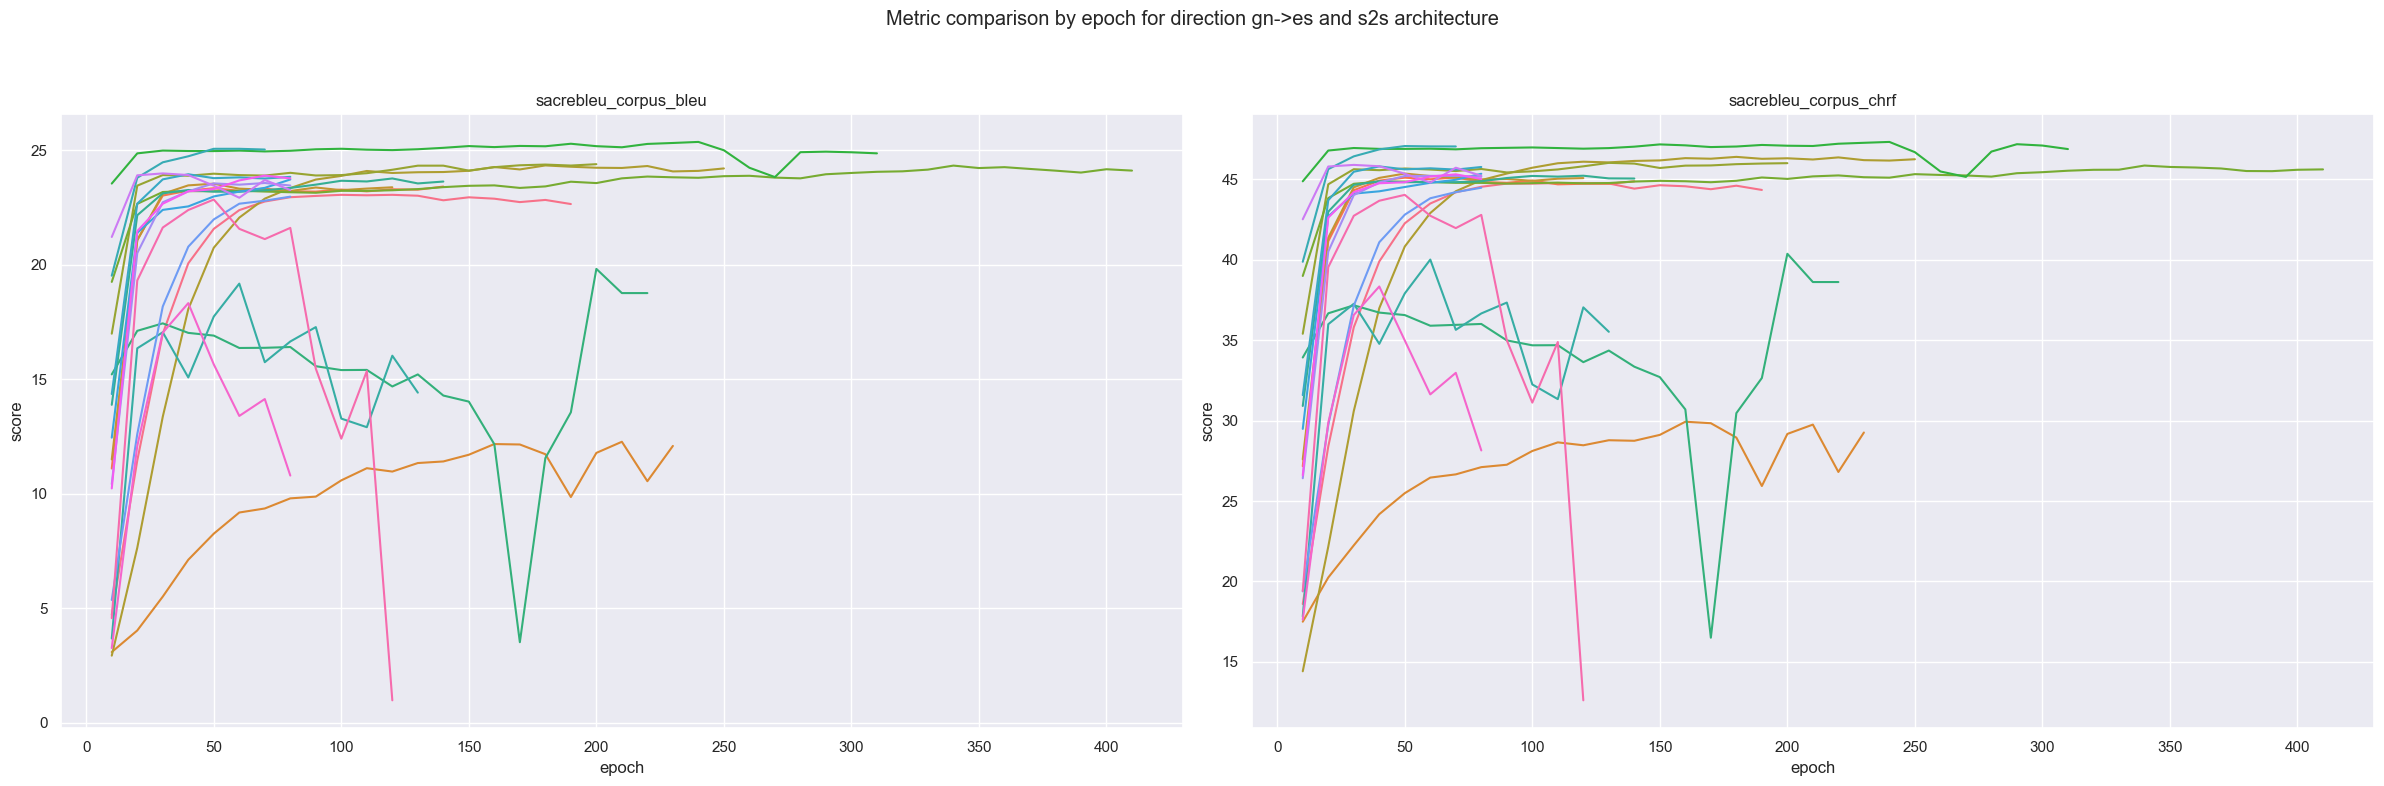

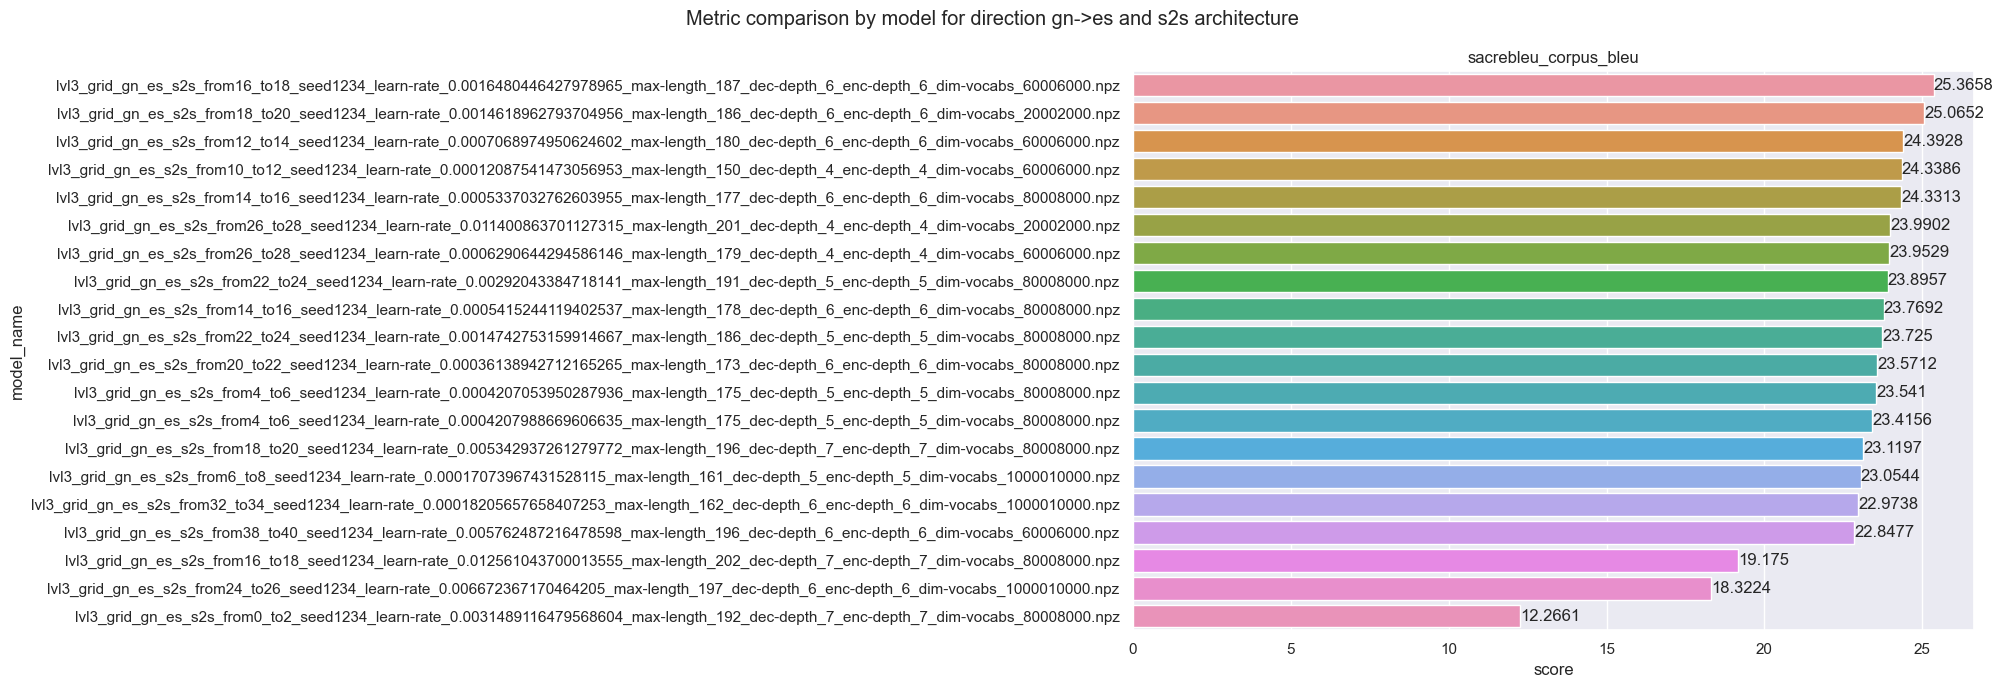

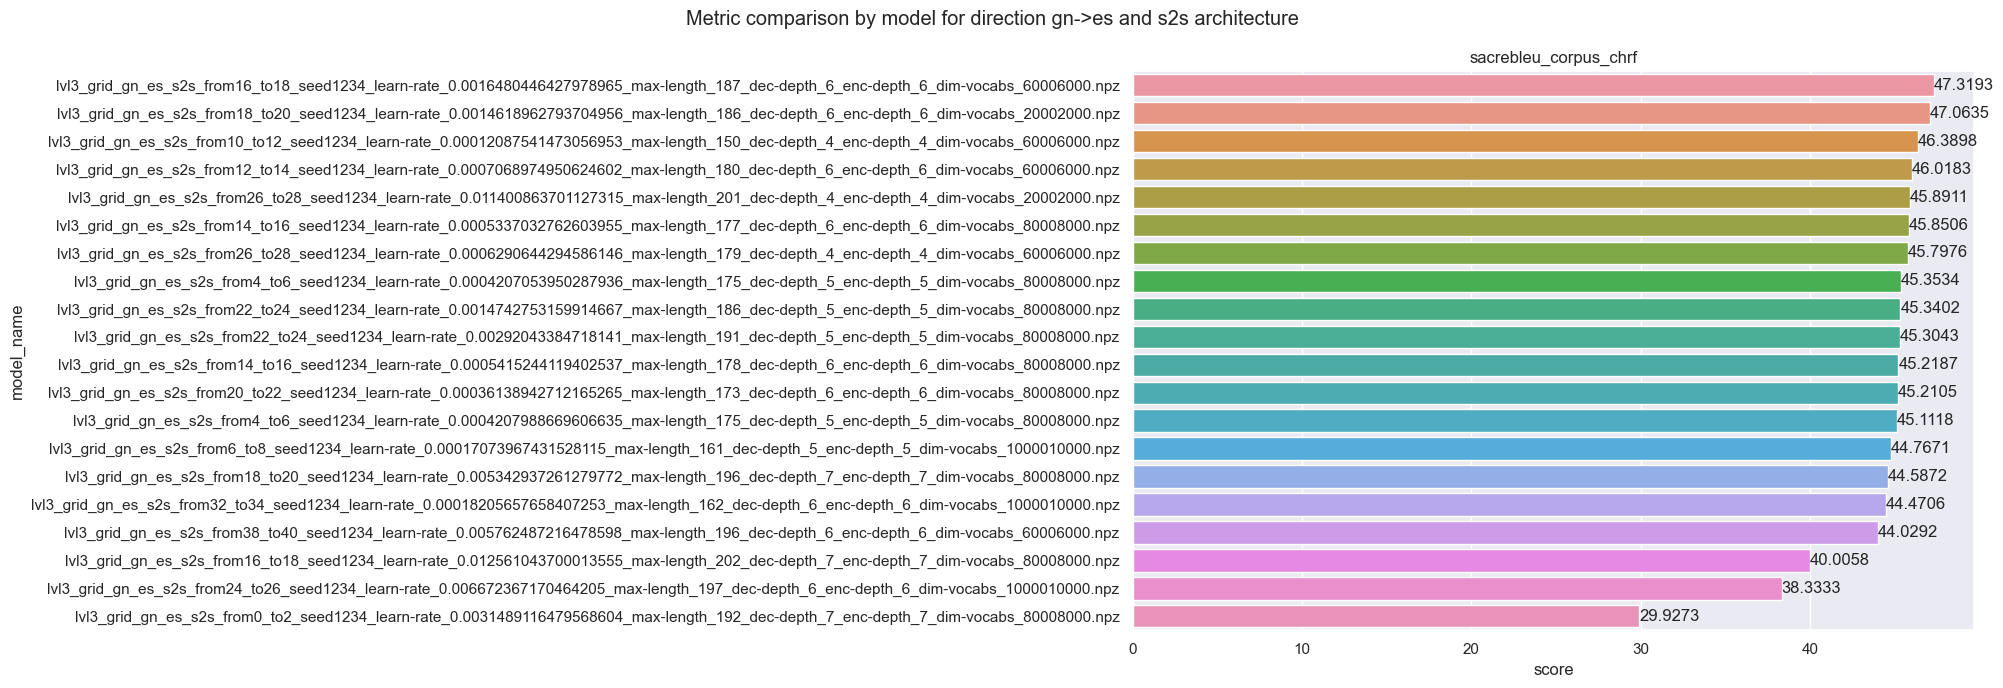

In [183]:
plots.plot_metric_by_epoch_foreach_model(gn_es_lvl3_results_df,
                                         metrics=['sacrebleu_corpus_bleu',
                                                  'sacrebleu_corpus_chrf'],
                                         figsize=(24,8), 
                                         legend=False);
plots.plot_max_score_by_model(gn_es_lvl3_results_df,
                              metrics=['sacrebleu_corpus_bleu'],
                              figsize=(20,7));
plots.plot_max_score_by_model(gn_es_lvl3_results_df,
                              metrics=['sacrebleu_corpus_chrf'],
                              figsize=(20,7));

In [206]:
best_model_s2s_gn_es = gn_es_lvl3_results_df.sort_values('score', 
                                                         ascending=False).head(1)
gn_es_lvl3_results_df[gn_es_lvl3_results_df['parameters']==best_model_s2s_gn_es['parameters'].values[0]].tail(2)

date  \
612  2023-08-11 21:30:35.106412   
613  2023-08-11 21:30:35.106412   

                                            model_name           source  \
612  lvl3_grid_gn_es_s2s_from16_to18_seed1234_learn...  valid_gn.txt.gn   
613  lvl3_grid_gn_es_s2s_from16_to18_seed1234_learn...  valid_gn.txt.gn   

              target             score_type      score  epoch  \
612  valid_es.txt.es  sacrebleu_corpus_chrf  47.319293    140   
613  valid_es.txt.es  sacrebleu_corpus_bleu  25.365785    140   

                                            parameters  
612  {'type': ['s2s'], 'max-length-crop': [], 'drop...  
613  {'type': ['s2s'], 'max-length-crop': [], 'drop...

##### **S2S: ES -> GN**

In [185]:
es_gn_lvl3_results_df = pd.read_csv(LVL3_S2S_ES_GN_RESULTS)
es_gn_lvl3_results_df = es_gn_lvl3_results_df[es_gn_lvl3_results_df['score'] > 0]
es_gn_lvl3_results_df.tail()

date  \
1383  2023-08-29 23:17:40.536005   
1384  2023-08-30 00:50:53.248328   
1385  2023-08-30 00:50:53.248328   
1386  2023-08-30 02:23:45.270896   
1387  2023-08-30 02:23:45.270896   

                                             model_name           source  \
1383  lvl3_grid_es_gn_s2s_from36_to40_seed1234_learn...  valid_es.txt.es   
1384  lvl3_grid_es_gn_s2s_from36_to40_seed1234_learn...  valid_es.txt.es   
1385  lvl3_grid_es_gn_s2s_from36_to40_seed1234_learn...  valid_es.txt.es   
1386  lvl3_grid_es_gn_s2s_from36_to40_seed1234_learn...  valid_es.txt.es   
1387  lvl3_grid_es_gn_s2s_from36_to40_seed1234_learn...  valid_es.txt.es   

               target             score_type      score  epoch  \
1383  valid_gn.txt.gn  sacrebleu_corpus_bleu   5.580938     80   
1384  valid_gn.txt.gn  sacrebleu_corpus_chrf  35.593998     90   
1385  valid_gn.txt.gn  sacrebleu_corpus_bleu  16.089973     90   
1386  valid_gn.txt.gn  sacrebleu_corpus_chrf   9.012097    100   
1387  valid_gn.txt.gn  sacrebleu_corpus_bleu   0.453377    100   

                                             parameters  
1383  {'type': ['s2s'], 'max-length-crop': [], 'drop...  
1384  {'type': ['s2s'], 'max-length-crop': [], 'drop...  
1385  {'type': ['s2s'], 'max-length-crop': [], 'drop...  
1386  {'type': ['s2s'], 'max-length-crop': [], 'drop...  
1387  {'type': ['s2s'], 'max-length-crop': [], 'drop...

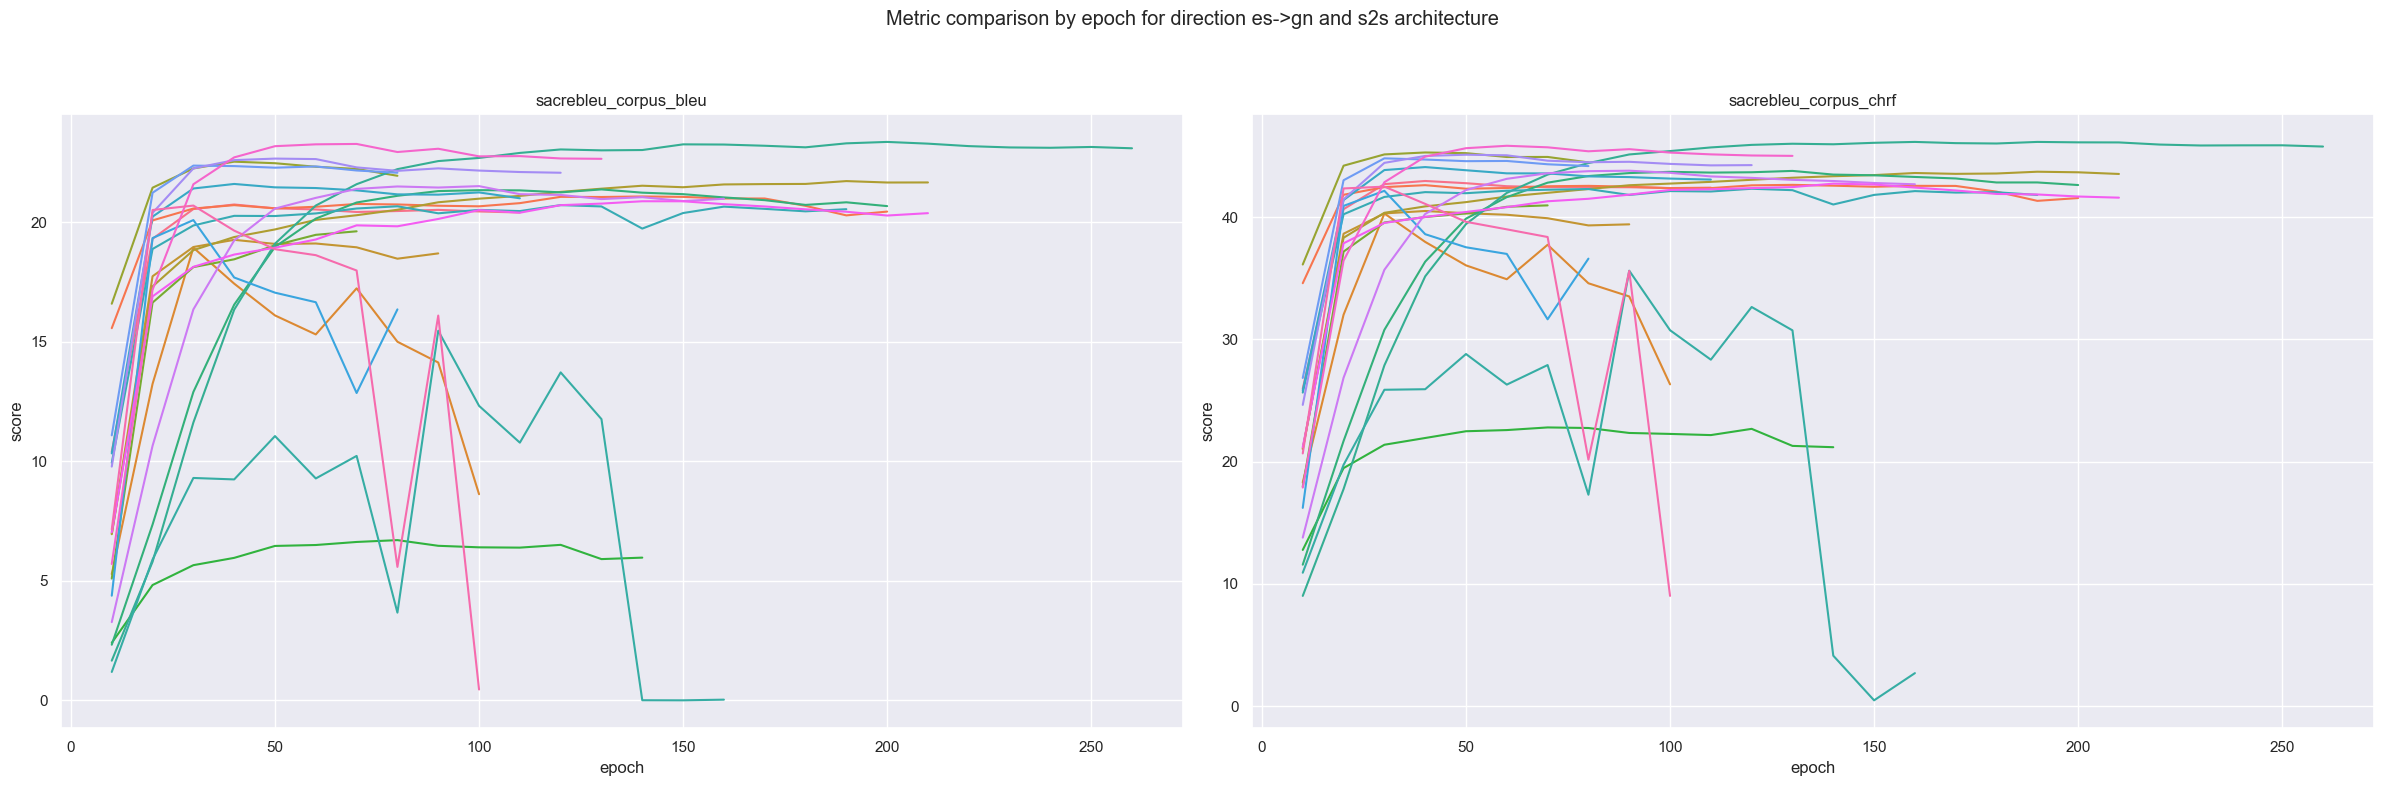

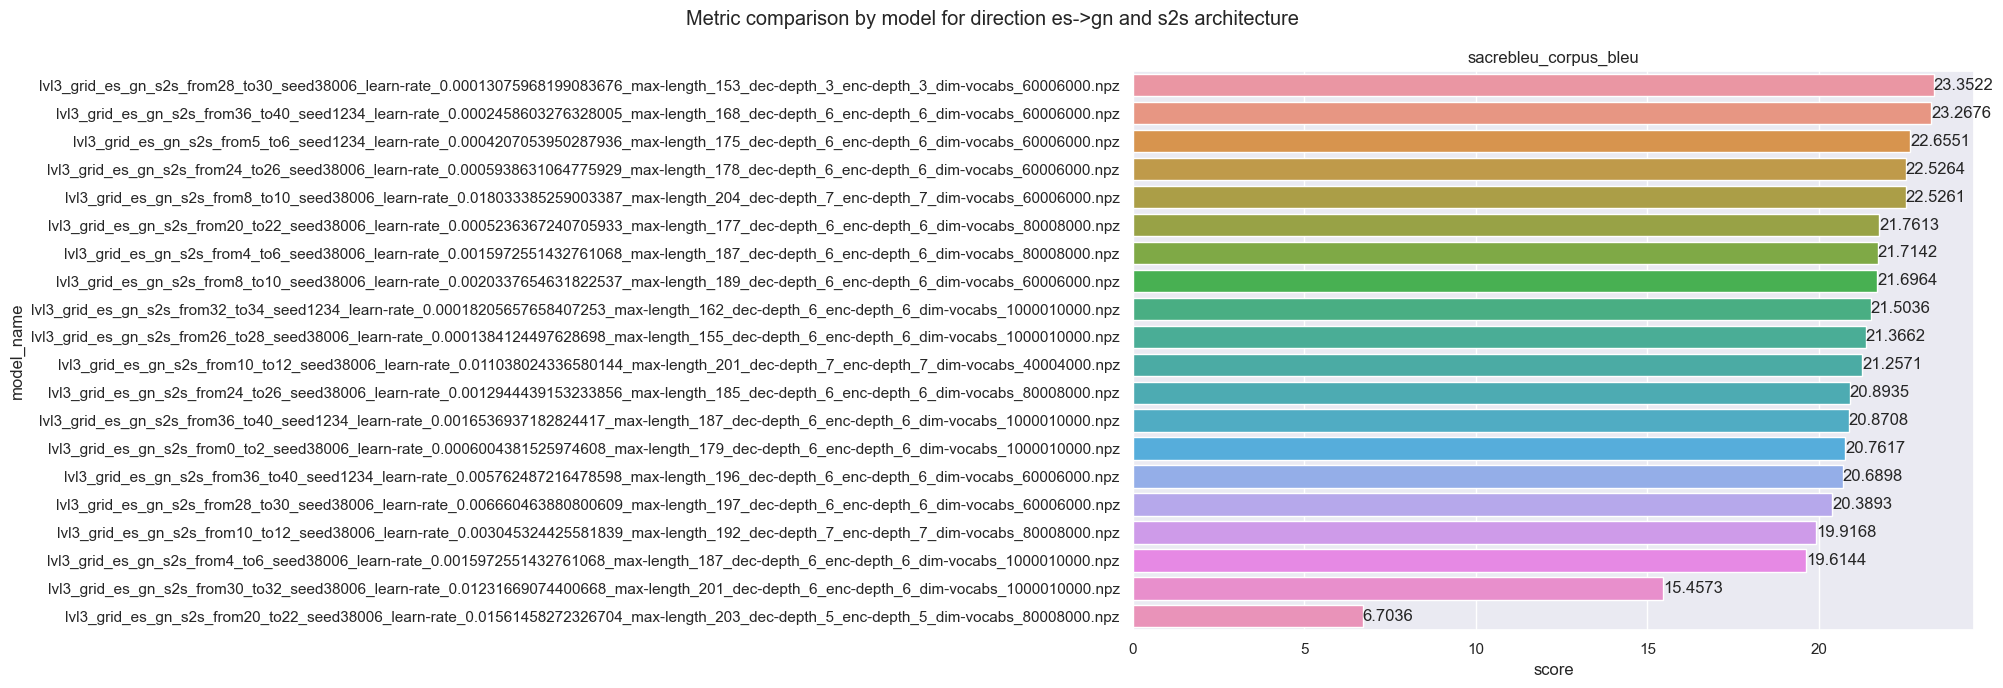

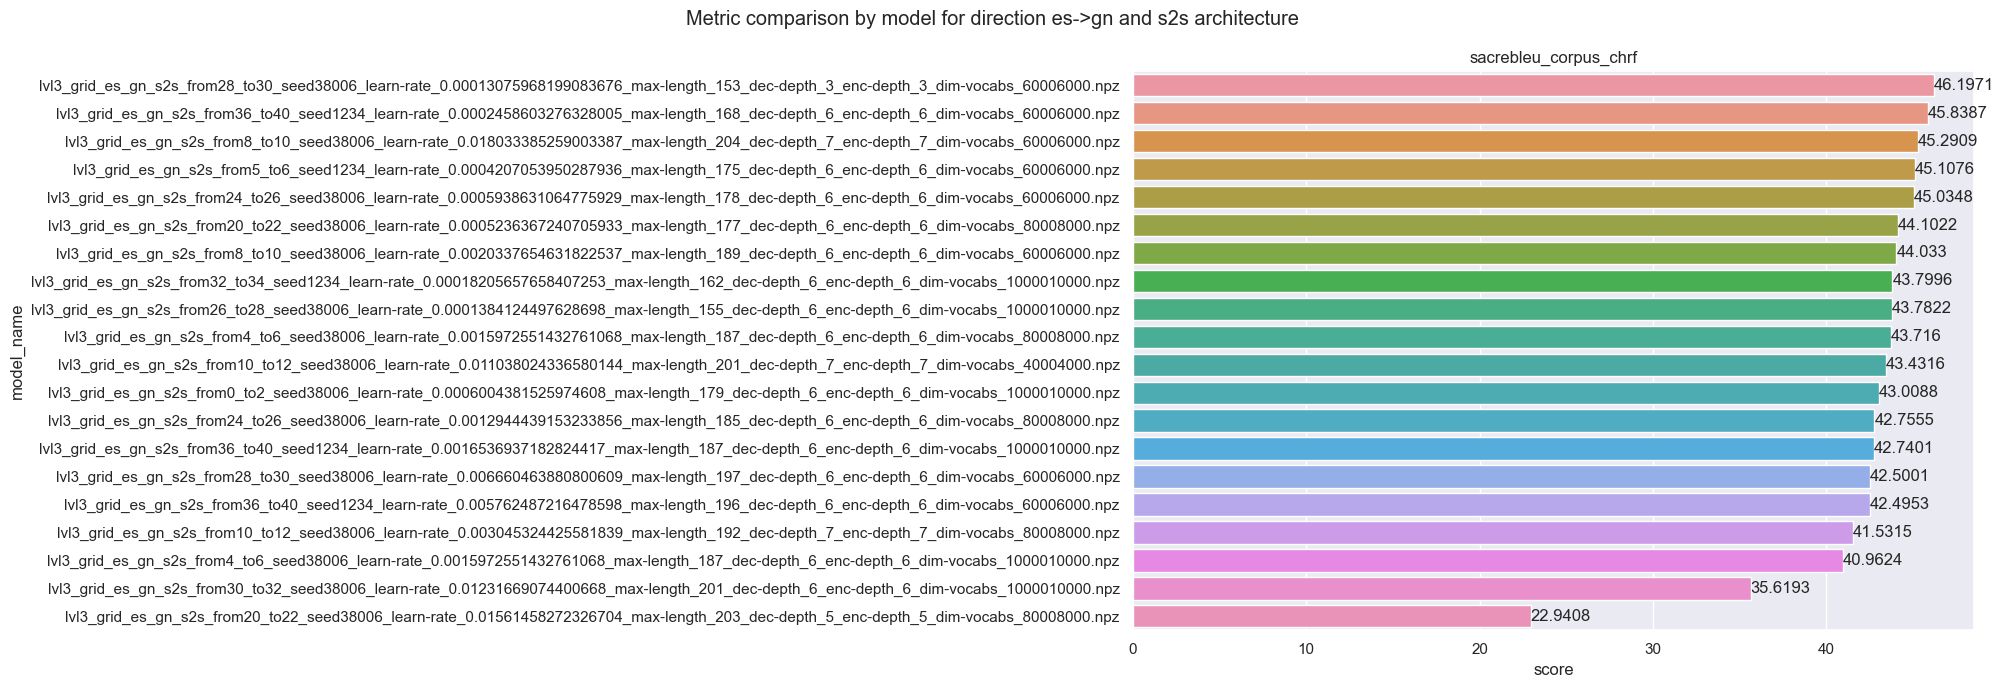

In [186]:
plots.plot_metric_by_epoch_foreach_model(es_gn_lvl3_results_df, 
                                         metrics=['sacrebleu_corpus_bleu', 
                                                  'sacrebleu_corpus_chrf'], 
                                         figsize=(24,8), 
                                         legend=False);
plots.plot_max_score_by_model(es_gn_lvl3_results_df, 
                              metrics=['sacrebleu_corpus_bleu'], 
                              figsize=(20,7));
plots.plot_max_score_by_model(es_gn_lvl3_results_df, 
                              metrics=['sacrebleu_corpus_chrf'], 
                              figsize=(20,7));

In [210]:
best_model_s2s_es_gn = es_gn_lvl3_results_df.sort_values('score', 
                                                         ascending=False).head(1)
es_gn_lvl3_results_df[es_gn_lvl3_results_df['parameters']==best_model_s2s_es_gn['parameters'].values[0]].head(2)

date  \
566  2023-08-16 11:44:10.613862   
567  2023-08-16 11:44:10.613862   

                                            model_name           source  \
566  lvl3_grid_es_gn_s2s_from28_to30_seed38006_lear...  valid_es.txt.es   
567  lvl3_grid_es_gn_s2s_from28_to30_seed38006_lear...  valid_es.txt.es   

              target             score_type      score  epoch  \
566  valid_gn.txt.gn  sacrebleu_corpus_chrf  46.197128    190   
567  valid_gn.txt.gn  sacrebleu_corpus_bleu  23.323922    190   

                                            parameters  
566  {'type': ['s2s'], 'max-length-crop': [], 'drop...  
567  {'type': ['s2s'], 'max-length-crop': [], 'drop...

##### **Transformer**

**GN->ES**

In [188]:
lvl3_transformer_gn_es_df = pd.read_csv(LVL3_TRANSFORMER_GN_ES_RESULTS)
lvl3_transformer_gn_es_df = lvl3_transformer_gn_es_df[lvl3_transformer_gn_es_df['score'] >= 0]
lvl3_transformer_gn_es_df.tail()

date  \
2817  2023-08-24 14:27:56.538356   
2818  2023-08-24 14:33:26.991378   
2819  2023-08-24 14:33:26.991378   
2820  2023-08-24 14:38:55.811697   
2821  2023-08-24 14:38:55.811697   

                                             model_name           source  \
2817  lvl3_grid_gn_es_transformer_from16_to18_seed60...  valid_gn.txt.gn   
2818  lvl3_grid_gn_es_transformer_from16_to18_seed60...  valid_gn.txt.gn   
2819  lvl3_grid_gn_es_transformer_from16_to18_seed60...  valid_gn.txt.gn   
2820  lvl3_grid_gn_es_transformer_from16_to18_seed60...  valid_gn.txt.gn   
2821  lvl3_grid_gn_es_transformer_from16_to18_seed60...  valid_gn.txt.gn   

               target             score_type      score  epoch  \
2817  valid_es.txt.es  sacrebleu_corpus_bleu  12.592470    340   
2818  valid_es.txt.es  sacrebleu_corpus_chrf  33.912185    350   
2819  valid_es.txt.es  sacrebleu_corpus_bleu  12.506665    350   
2820  valid_es.txt.es  sacrebleu_corpus_chrf  34.095357    360   
2821  valid_es.txt.es  sacrebleu_corpus_bleu  12.672722    360   

                                             parameters  
2817  {'type': ['transformer'], 'max-length-crop': [...  
2818  {'type': ['transformer'], 'max-length-crop': [...  
2819  {'type': ['transformer'], 'max-length-crop': [...  
2820  {'type': ['transformer'], 'max-length-crop': [...  
2821  {'type': ['transformer'], 'max-length-crop': [...

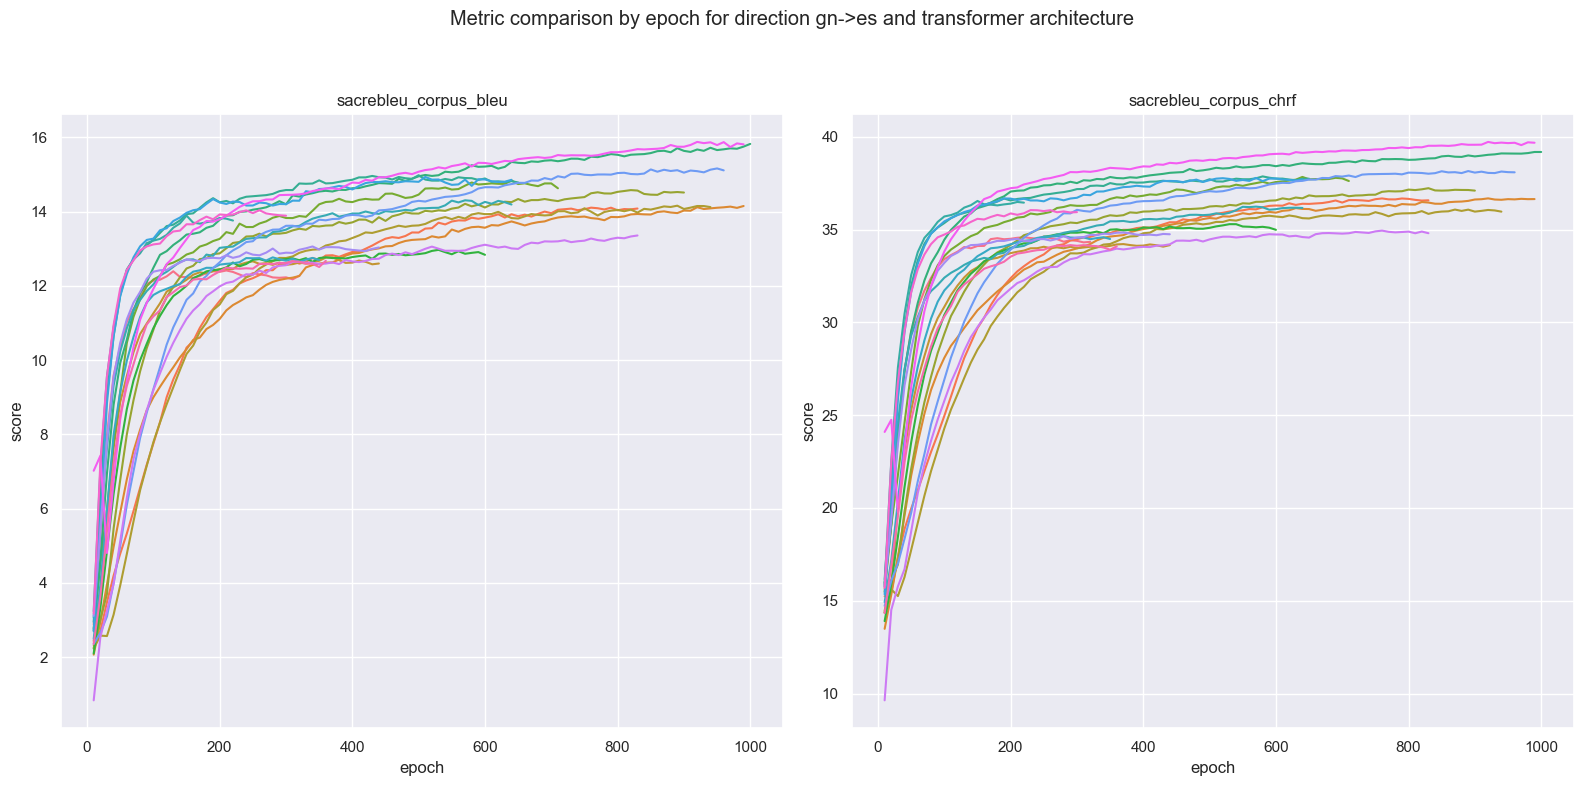

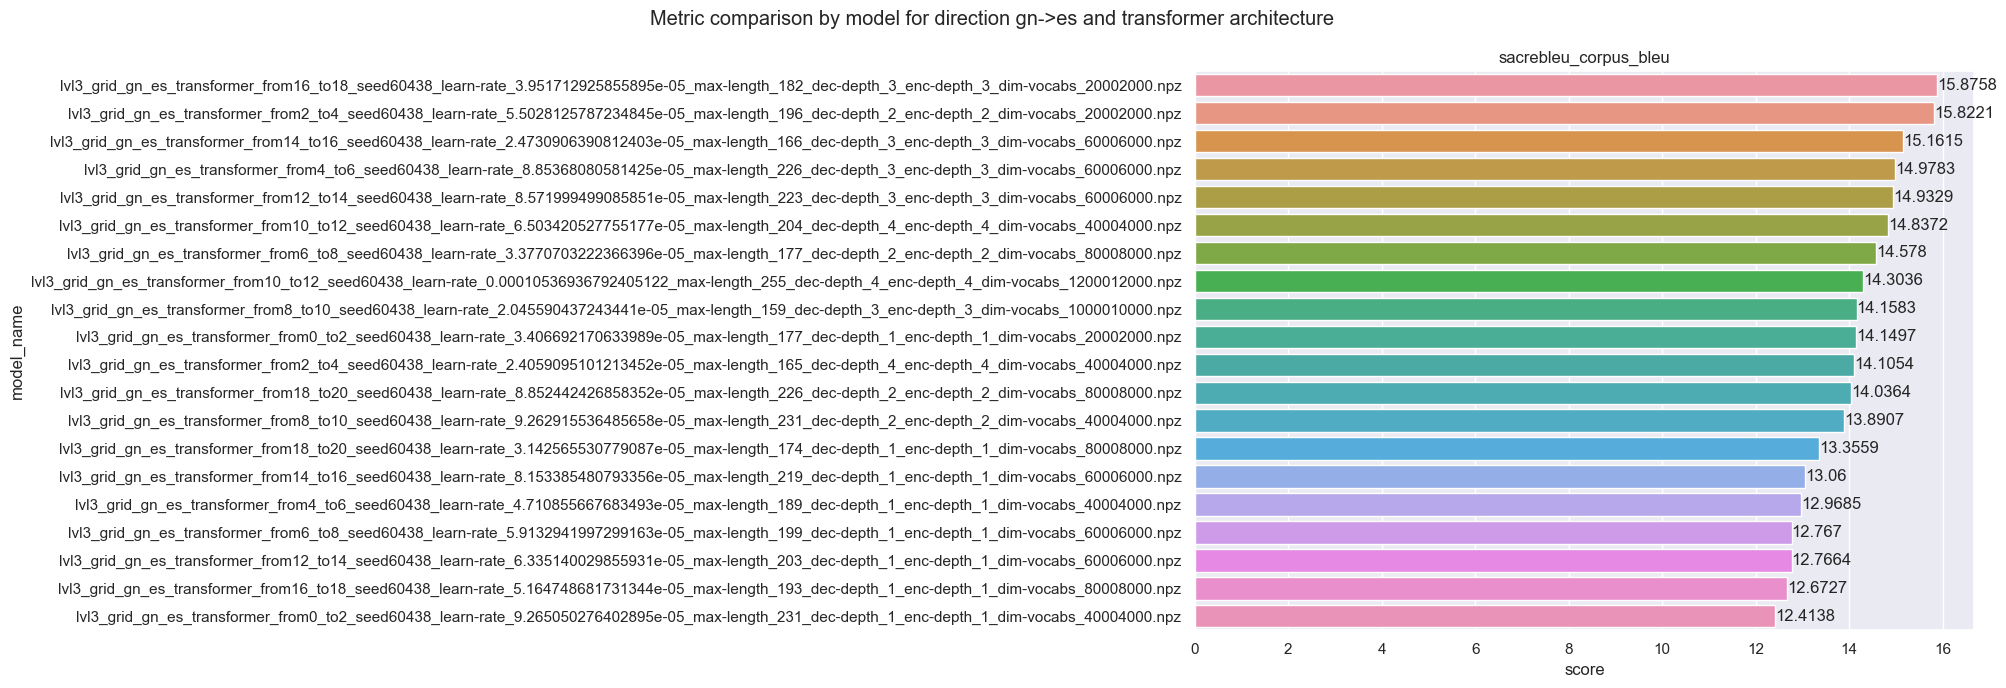

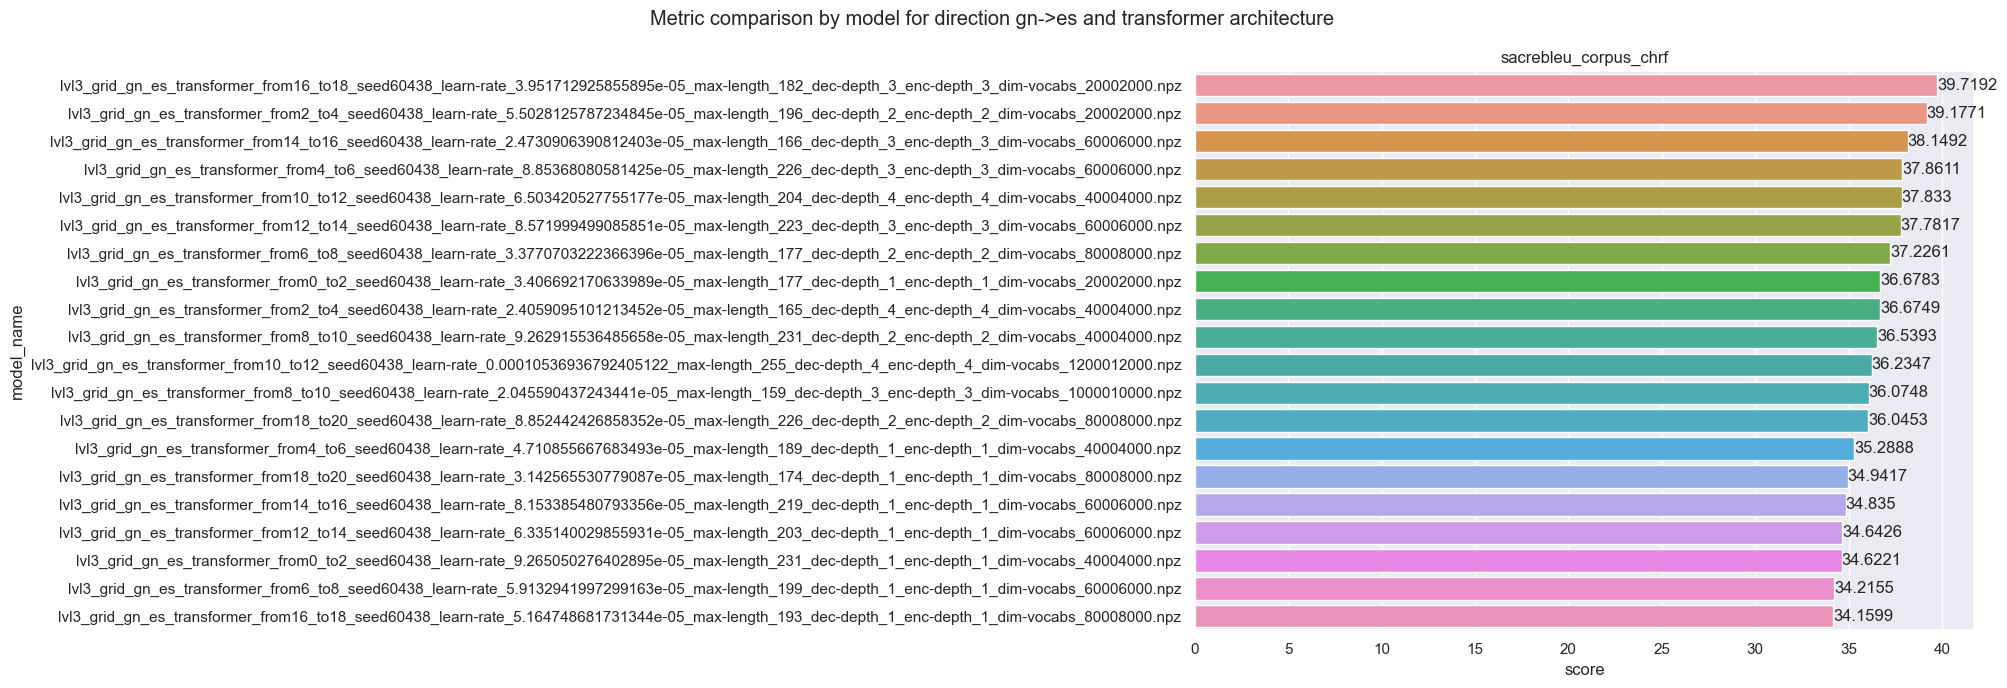

In [189]:
plots.plot_metric_by_epoch_foreach_model(lvl3_transformer_gn_es_df, 
                                         metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], 
                                         figsize=(16,8), 
                                         legend=False);
plots.plot_max_score_by_model(lvl3_transformer_gn_es_df, 
                              metrics=['sacrebleu_corpus_bleu'], 
                              figsize=(20,7));
plots.plot_max_score_by_model(lvl3_transformer_gn_es_df, 
                              metrics=['sacrebleu_corpus_chrf'], 
                              figsize=(20,7));

In [221]:
best_model_transformer_gn_es = lvl3_transformer_gn_es_df.sort_values('score', ascending=False).head(1)
lvl3_transformer_gn_es_df[lvl3_transformer_gn_es_df['parameters']==best_model_transformer_gn_es['parameters'].values[0]].head(2)

date  \
2734  2023-08-24 10:03:52.144057   
2735  2023-08-24 10:03:52.144057   

                                             model_name           source  \
2734  lvl3_grid_gn_es_transformer_from16_to18_seed60...  valid_gn.txt.gn   
2735  lvl3_grid_gn_es_transformer_from16_to18_seed60...  valid_gn.txt.gn   

               target             score_type      score  epoch  \
2734  valid_es.txt.es  sacrebleu_corpus_chrf  39.719175    920   
2735  valid_es.txt.es  sacrebleu_corpus_bleu  15.875761    920   

                                             parameters  
2734  {'type': ['transformer'], 'max-length-crop': [...  
2735  {'type': ['transformer'], 'max-length-crop': [...

**Transformer**

**ES->GN**

In [191]:
lvl3_transformer_es_gn_df = pd.read_csv(LVL3_TRANSFORMER_ES_GN_RESULTS)
lvl3_transformer_es_gn_df = lvl3_transformer_es_gn_df[lvl3_transformer_es_gn_df['score'] > 0]
lvl3_transformer_es_gn_df.head()

date  \
0  2023-08-20 14:30:57.399870   
1  2023-08-20 14:30:57.399870   
2  2023-08-20 14:38:02.769007   
3  2023-08-20 14:38:02.769007   
4  2023-08-20 14:44:47.938906   

                                          model_name           source  \
0  lvl3_grid_es_gn_transformer_from0_to2_seed3088...  valid_es.txt.es   
1  lvl3_grid_es_gn_transformer_from0_to2_seed3088...  valid_es.txt.es   
2  lvl3_grid_es_gn_transformer_from0_to2_seed3088...  valid_es.txt.es   
3  lvl3_grid_es_gn_transformer_from0_to2_seed3088...  valid_es.txt.es   
4  lvl3_grid_es_gn_transformer_from0_to2_seed3088...  valid_es.txt.es   

            target             score_type     score  epoch  \
0  valid_gn.txt.gn  sacrebleu_corpus_chrf  4.066554     10   
1  valid_gn.txt.gn  sacrebleu_corpus_bleu  0.039525     10   
2  valid_gn.txt.gn  sacrebleu_corpus_chrf  6.737243     20   
3  valid_gn.txt.gn  sacrebleu_corpus_bleu  1.072929     20   
4  valid_gn.txt.gn  sacrebleu_corpus_chrf  7.799798     30   

                                          parameters  
0  {'quiet-translation': [], 'overwrite': [], 'ea...  
1  {'quiet-translation': [], 'overwrite': [], 'ea...  
2  {'quiet-translation': [], 'overwrite': [], 'ea...  
3  {'quiet-translation': [], 'overwrite': [], 'ea...  
4  {'quiet-translation': [], 'overwrite': [], 'ea...

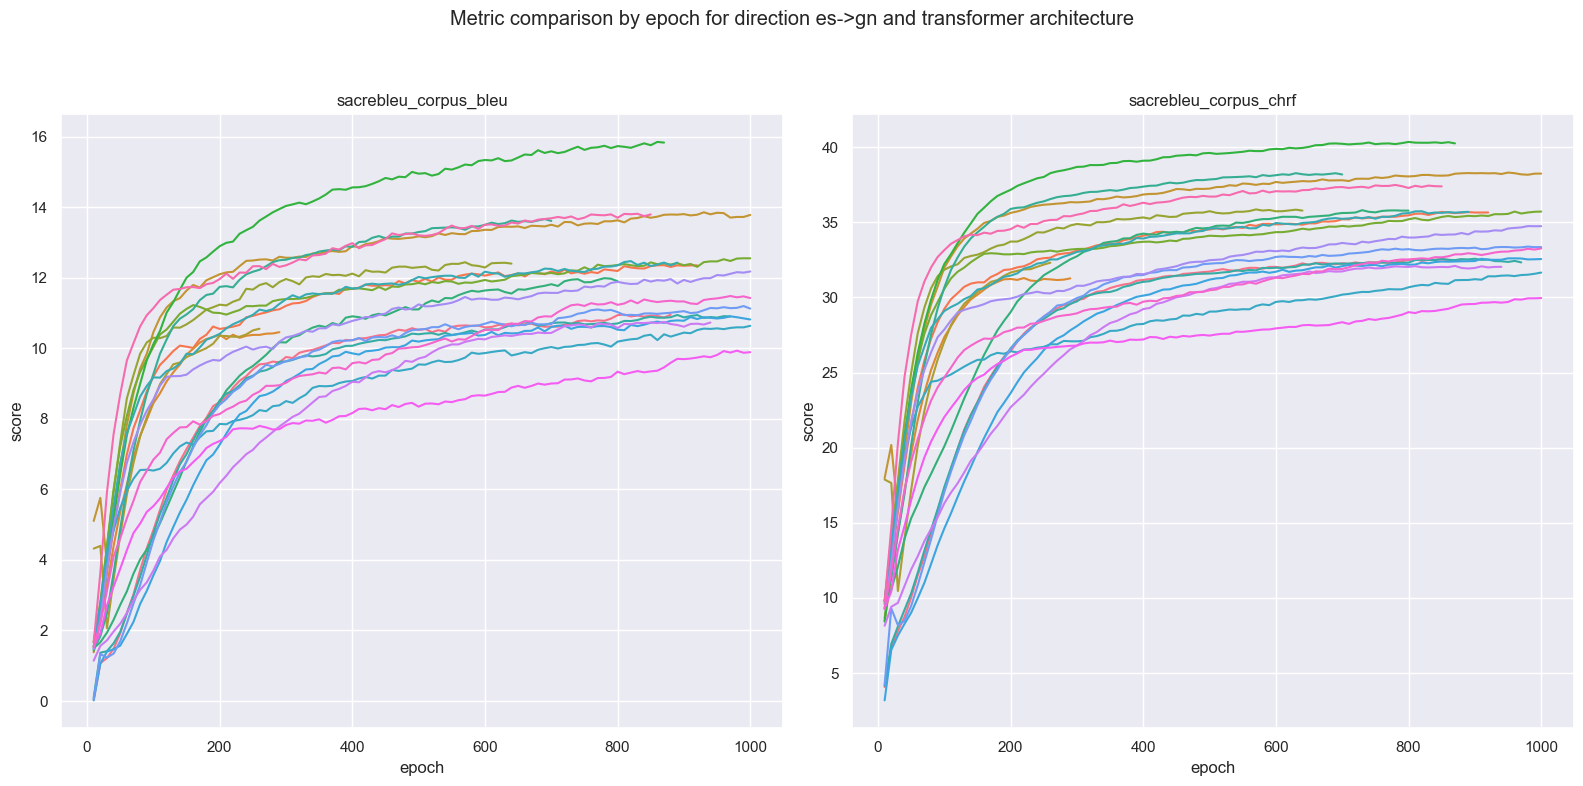

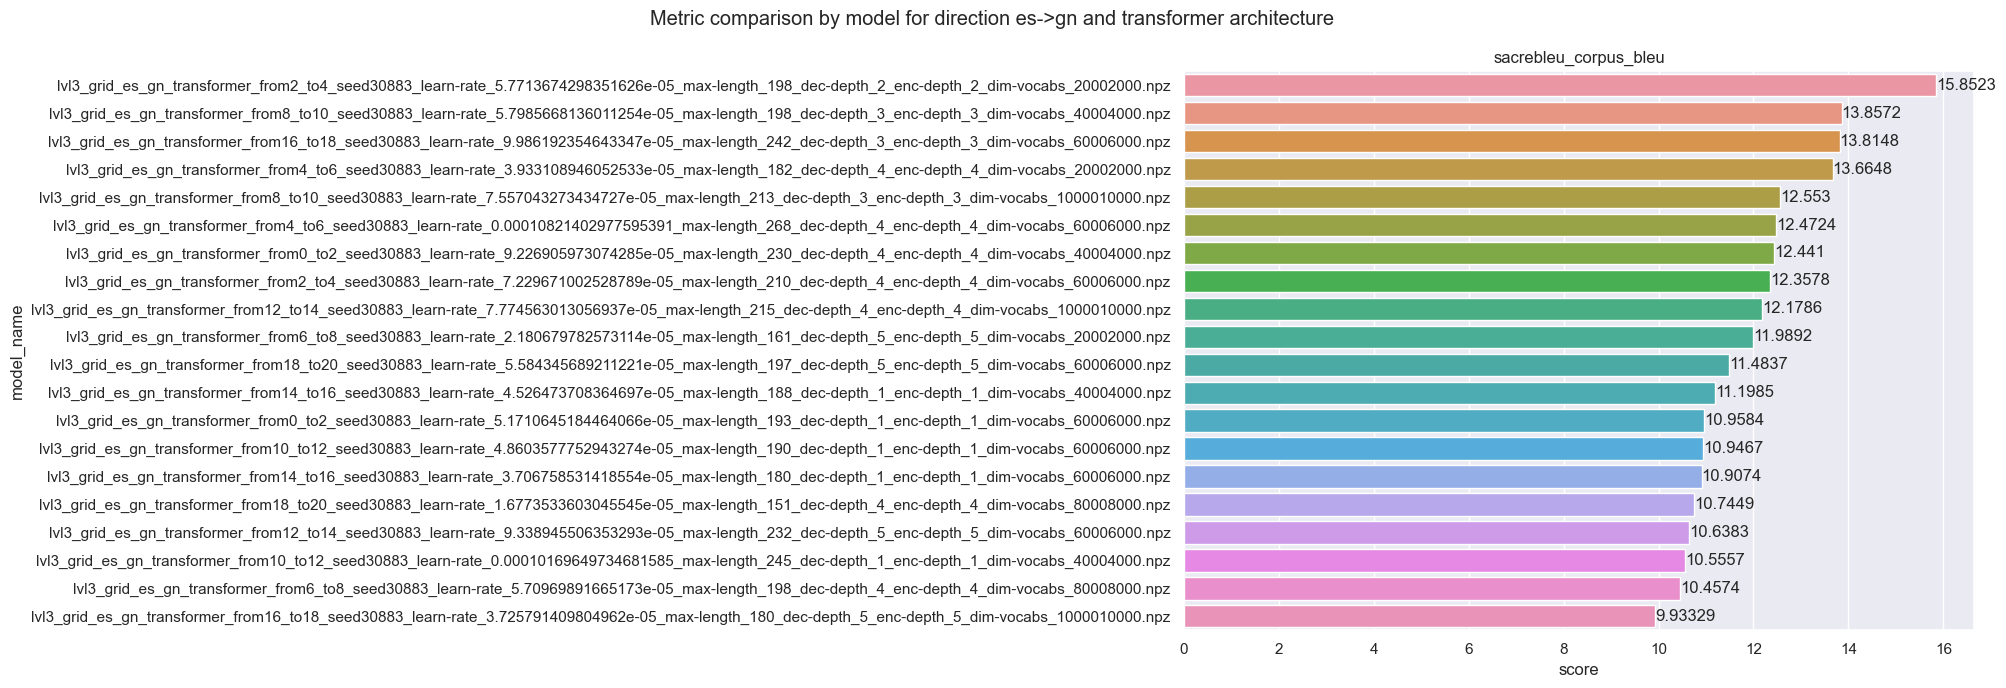

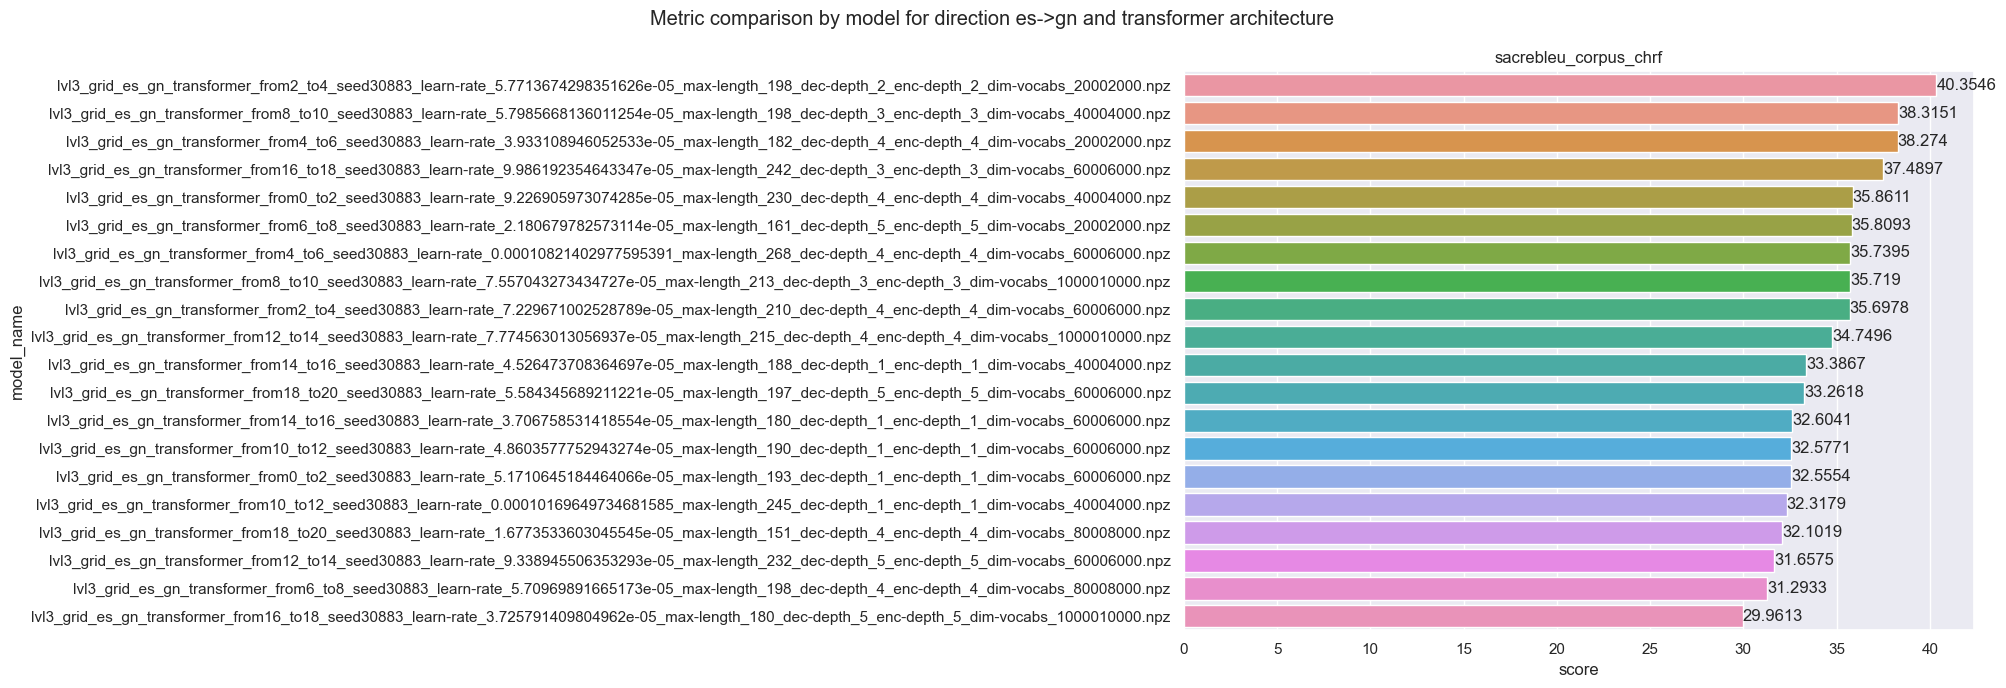

In [192]:
plots.plot_metric_by_epoch_foreach_model(lvl3_transformer_es_gn_df, 
                                         metrics=['sacrebleu_corpus_bleu', 
                                                  'sacrebleu_corpus_chrf'], 
                                         figsize=(16,8), 
                                         legend=False);
plots.plot_max_score_by_model(lvl3_transformer_es_gn_df, 
                              metrics=['sacrebleu_corpus_bleu'], 
                              figsize=(20,7));
plots.plot_max_score_by_model(lvl3_transformer_es_gn_df, 
                              metrics=['sacrebleu_corpus_chrf'], 
                              figsize=(20,7));

In [213]:
best_model_transformer_es_gn = lvl3_transformer_es_gn_df.sort_values('score', ascending=False).head(1)
lvl3_transformer_es_gn_df[lvl3_transformer_es_gn_df['parameters']==best_model_transformer_es_gn['parameters'].values[0]].head(2)

date  \
1948  2023-08-21 20:57:50.276785   
1949  2023-08-21 20:57:50.276785   

                                             model_name           source  \
1948  lvl3_grid_es_gn_transformer_from2_to4_seed3088...  valid_es.txt.es   
1949  lvl3_grid_es_gn_transformer_from2_to4_seed3088...  valid_es.txt.es   

               target             score_type      score  epoch  \
1948  valid_gn.txt.gn  sacrebleu_corpus_chrf  40.354648    800   
1949  valid_gn.txt.gn  sacrebleu_corpus_bleu  15.734143    800   

                                             parameters  
1948  {'quiet-translation': [], 'overwrite': [], 'ea...  
1949  {'quiet-translation': [], 'overwrite': [], 'ea...

### **LVL3 Summary**

In [194]:
lvl3_results = [best_model_s2s_gn_es,
                best_model_s2s_es_gn,
                best_model_transformer_gn_es,
                best_model_transformer_es_gn]

In [195]:
def create_lvl3_summary(lvl3_results: list[pd.DataFrame]):
    summary_df = {"model_name": [], 
                  "source_language": [], 
                  "target_language": [], 
                  "score_type": [], 
                  "score": []}
    
    for df in lvl3_results:
        for _, row in df.iterrows():
            summary_df['model_name'].append(row['model_name'])
            summary_df['source_language'].append(row['source'])
            summary_df['target_language'].append(row['target'])
            summary_df['score_type'].append(row['score_type'])
            summary_df['score'].append(row['score'])

    return pd.DataFrame(summary_df)

In [196]:
summary_df = create_lvl3_summary(lvl3_results)
summary_df

model_name  source_language  \
0  lvl3_grid_gn_es_s2s_from16_to18_seed1234_learn...  valid_gn.txt.gn   
1  lvl3_grid_es_gn_s2s_from28_to30_seed38006_lear...  valid_es.txt.es   
2  lvl3_grid_gn_es_transformer_from16_to18_seed60...  valid_gn.txt.gn   
3  lvl3_grid_es_gn_transformer_from2_to4_seed3088...  valid_es.txt.es   

   target_language             score_type      score  
0  valid_es.txt.es  sacrebleu_corpus_chrf  47.319293  
1  valid_gn.txt.gn  sacrebleu_corpus_chrf  46.197128  
2  valid_es.txt.es  sacrebleu_corpus_chrf  39.719175  
3  valid_gn.txt.gn  sacrebleu_corpus_chrf  40.354648

In [197]:
def extract_hyperparameters(df: pd.DataFrame, 
                            features: list, 
                            from_='model_name'):
    features_df = {feature: [] for feature in features}
    for feature in features:
        sep = '_' if feature != 'seed' else ''
        regex = f'{feature}{sep}([^_]+)'
        extracted_features = df[from_].str.extract(regex)[0].tolist()
        features_df[feature].extend(extracted_features)

    return pd.DataFrame(features_df)

In [198]:
features = ["seed", 
            "learn-rate", 
            "max-length", 
            "dec-depth", 
            "enc-depth", 
            "dim-vocabs"]
hyperparameter_df = extract_hyperparameters(summary_df, features)
pd.concat([summary_df, hyperparameter_df], axis=1)

model_name  source_language  \
0  lvl3_grid_gn_es_s2s_from16_to18_seed1234_learn...  valid_gn.txt.gn   
1  lvl3_grid_es_gn_s2s_from28_to30_seed38006_lear...  valid_es.txt.es   
2  lvl3_grid_gn_es_transformer_from16_to18_seed60...  valid_gn.txt.gn   
3  lvl3_grid_es_gn_transformer_from2_to4_seed3088...  valid_es.txt.es   

   target_language             score_type      score   seed  \
0  valid_es.txt.es  sacrebleu_corpus_chrf  47.319293   1234   
1  valid_gn.txt.gn  sacrebleu_corpus_chrf  46.197128  38006   
2  valid_es.txt.es  sacrebleu_corpus_chrf  39.719175  60438   
3  valid_gn.txt.gn  sacrebleu_corpus_chrf  40.354648  30883   

               learn-rate max-length dec-depth enc-depth    dim-vocabs  
0   0.0016480446427978965        187         6         6  60006000.npz  
1  0.00013075968199083676        153         3         3  60006000.npz  
2   3.951712925855895e-05        182         3         3  20002000.npz  
3  5.7713674298351626e-05        198         2         2  20002000.npz

In [199]:
all_dfs = [lvl3_transformer_es_gn_df, 
           lvl3_transformer_gn_es_df, 
           gn_es_lvl3_results_df, 
           es_gn_lvl3_results_df]

best_models_df = [df[df['model_name'].isin(summary_df['model_name'])] \
                  for df in all_dfs]
best_models_df = pd.concat(best_models_df, axis=0)
best_models_df.to_csv(BEST_MODELS_CSV)